# Libraries

In [4]:
import pandas as pd
import numpy as np
import math
from scipy.stats.stats import describe
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.utils import resample
from numpy.lib.npyio import save
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn import metrics
from sklearn.impute import KNNImputer
import datetime
import os
from pandas.plotting import scatter_matrix
from sklearn.impute import KNNImputer
import statsmodels.api as sm
import pylab as py
from scipy import stats
import pickle

C:\Users\Ali\AppData\Local\Temp\ipykernel_22044\3812817670.py:4: DeprecationWarning: Please use `describe` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import describe


# Functions

In [2]:
def remove_collinear_features(x, threshold):
        print('--------------------')
        print('Collinear features\n')
        # Calculate the correlation matrix
        corr_matrix = x.corr()
        iters = range(len(corr_matrix.columns) - 1)
        drop_cols = []

        # Iterate through the correlation matrix and compare correlations
        for i in iters:
            for j in range(i + 1):
                item = corr_matrix.iloc[j:(j + 1), (i + 1):(i + 2)]
                col = item.columns
                row = item.index
                val = abs(item.values)

                # If correlation exceeds the threshold
                if val >= threshold:
                    # Print the correlated features and the correlation value
                    print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                    missing_perc1 = round(x[col.values[0]].isnull().sum() / len(df) * 100, 2)
                    missing_perc2 = round(x[row.values[0]].isnull().sum() / len(df) * 100, 2)
                    print(col.values[0], ': ', missing_perc1, '% of missing')
                    print(row.values[0], ': ', missing_perc2, '% of missing')
                    if missing_perc1 > missing_perc2:
                        drop_cols.append(col.values[0])
                        print(col.values[0], ' has more missing valus, it will be removed')
                    else:
                        drop_cols.append(row.values[0])
                        print(row.values[0], ' has more missing valus, it will be removed')

        # Drop one of each pair of correlated columns
        drops = set(drop_cols)
        x = x.drop(columns=drops)
        print('--------------------\n')

        return x

def hyperp_search(classifier, parameters):
    gs = GridSearchCV(classifier, parameters, cv=3, scoring = 'f1', verbose=0, n_jobs=-1)
    gs = gs.fit(X_train, y_train)
    print("f1_train: %f using %s" % (gs.best_score_, gs.best_params_))

    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_train)

    print("f1         train %.3f   test %.3f" % (f1_score(y_train, y_pred_train), f1_score(y_test, y_pred) )) 
    print("precision  train %.3f   test %.3f" % (precision_score(y_train, y_pred_train), precision_score(y_test, y_pred) )) 
    print("")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return best_model
    
def report_save(model,model_name):
        y_pre = model.predict(X_test)

        y_probs = model.predict_proba(
            X_test)  # predict_proba gives the probabilities for the target (0 and 1 in your case)
        save_root = "./checkpoint/{}_{}".format(datetime.datetime.now().strftime("%m-%d-%H%M"),model_name)
        os.makedirs(save_root, exist_ok=True)
        # auc computation
        auc = metrics.roc_auc_score(y_test, y_probs[:, 1])
        print('AUC: %.2f' % auc)

        # heatmap plot
        sns.heatmap(confusion_matrix(y_test, y_pre), annot=True, fmt='d', cmap="Blues")
        plt.savefig('{}/heat.png'.format(save_root), bbox_inches='tight')
        plt.clf()

        # auc plot
        fpr, tpr, thresholds1 = metrics.roc_curve(y_test, y_probs[:, 1])
        plt.plot(fpr, tpr, label='ROC')
        plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend()
        plt.savefig('{}/roc.png'.format(save_root), bbox_inches='tight')
        plt.clf()

        pickle.dump(best_model, open('{}/model.pkl'.format(save_root), 'wb'))
        

# Driver connection

In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

# Data Union
Create a new dataset that include also the drugs information. The new dataset will be save into a csv file if use the solution 2.

In [5]:
# solution 1
df_original = pd.read_csv("dat.csv", sep=",", index_col=0)
df_drug = pd.read_csv("dat_md.csv", sep=",", index_col=0)
dummies_drug = pd.get_dummies(df_drug)
df_drug = dummies_drug.groupby('inpatient.number').max().reset_index()
df_final = pd.merge(df_original, df_drug, on='inpatient.number', how='left')
for column in df_drug.columns:
    df_final[column].fillna(0, inplace=True)
df_orig = df_final

In [8]:
# solution 2 It will take a while
df_orig = pd.read_csv("dat.csv", sep = "," , index_col=0)
df_md = pd.read_csv("dat_md.csv", sep = "," , index_col=0)
mds = df_md['Drug_name'].unique() 
for md in mds:
  df_orig[md] = math.nan
mds = df_md['Drug_name'].unique() 
for md in mds:
  for pt in df_orig['inpatient.number']:
    if df_md.query('Drug_name ==  @md and `inpatient.number` == @pt').empty:
      df_orig.loc[df_orig['inpatient.number'] == pt,md] = 'no'
    else:
      df_orig.loc[df_orig['inpatient.number'] == pt,md] = 'yes'

df_orig.to_csv('new_data.csv', index=False)

# Preprocessing: Importing and Cleaning

In [3]:
# uncomment it when you use solution 2 for data union
#df_orig = pd.read_csv("new_data.csv", sep = ",")

In [4]:
# ---------Data Preprocessing------------
# remove patient unique ID
df = df_orig.drop(["inpatient.number"], axis=1)

# remove dead patients
df = df.drop(df[(df["death.within.28.days"] == 1) |
                (df["death.within.3.months"] == 1) |
                (df["death.within.6.months"] == 1) |
                (df["DestinationDischarge"] == "Died")
                ].index)

# remove useless attributes
features_to_drop = ['return.to.emergency.department.within.6.months',
                    'admission.way',
                    're.admission.within.3.months', 'dischargeDay',
                    're.admission.within.28.days', 're.admission.time..days.from.admission.',
                    'time.to.emergency.department.within.6.months',
                    'DestinationDischarge']
df = df.drop(columns=features_to_drop)

# remove features with more than 50% missing
missing_perc = df.isnull().sum() / len(df) * 100
features_to_drop = missing_perc[missing_perc > 50].index.tolist()
df = df.drop(columns=features_to_drop)

# add derivative feature
df['hypertension'] = df.apply(lambda row: 1 if (row['systolic.blood.pressure'] >= 120 or row['diastolic.blood.pressure'] >= 80) else 0,axis=1)

# ---------     Splitting    ------------
# numerical categorical splitting
df_categorical = df.select_dtypes(include=['object'])
df_numerical = df.select_dtypes(include=[np.number])
df_numerical = df_numerical.reset_index()
df_categorical = df_categorical.reset_index()
del df_numerical["index"]
del df_categorical["index"]

# target
temp = df_numerical['re.admission.within.6.months']
del df_numerical['re.admission.within.6.months']

# remove high collinear features
df_numerical = remove_collinear_features(df_numerical, 0.80)

--------------------
Collinear features

map | systolic.blood.pressure | 0.89
map :  0.0 % of missing
systolic.blood.pressure :  0.0 % of missing
systolic.blood.pressure  has more missing valus, it will be removed
map | diastolic.blood.pressure | 0.92
map :  0.0 % of missing
diastolic.blood.pressure :  0.0 % of missing
diastolic.blood.pressure  has more missing valus, it will be removed
verbal.response | eye.opening | 0.81
verbal.response :  0.0 % of missing
eye.opening :  0.0 % of missing
eye.opening  has more missing valus, it will be removed
hematocrit | red.blood.cell | 0.87
hematocrit :  1.34 % of missing
red.blood.cell :  1.28 % of missing
hematocrit  has more missing valus, it will be removed
mean.hemoglobin.volume | mean.corpuscular.volume | 0.94
mean.hemoglobin.volume :  1.34 % of missing
mean.corpuscular.volume :  1.34 % of missing
mean.corpuscular.volume  has more missing valus, it will be removed
basophil.count | basophil.ratio | 0.82
basophil.count :  1.28 % of missing
bas

# Data Observatory 1

### General information

In [ ]:
# general view plot
print('------------------------------------------------')
print('Numerical features\n')
print('Shape: ', df_numerical.shape)
print('Index: ', df_numerical.index)
print( "Number of missing data: " ,   df_numerical.isnull().sum().sum())
print('------------------------------------------------')
print('Catagorical features\n')
print('Shape: ', df_categorical.shape)
print('Index: ', df_categorical.index)
print('Number of missing data: ' ,   df_categorical.isnull().sum().sum())
print('------------------------------------------------')

### Missing value Percentage

In [ ]:
# Numerical
counter=0
for i, x in enumerate(df_numerical.columns):
    S=df_numerical[x].isnull().sum()
    t=len(df_numerical[x])
    p=round((S/t)*100)
    if p==1:
        counter +=1
        print(i,')',x,': NaN:',S,'perc:',p)
print("number of feature: ", counter)

31 ) creatinine.enzymatic.method : NaN: 21 perc: 1
32 ) urea : NaN: 21 perc: 1
33 ) uric.acid : NaN: 21 perc: 1
36 ) monocyte.ratio : NaN: 25 perc: 1
37 ) monocyte.count : NaN: 25 perc: 1
38 ) red.blood.cell : NaN: 25 perc: 1
39 ) coefficient.of.variation.of.red.blood.cell.distribution.width : NaN: 27 perc: 1
40 ) standard.deviation.of.red.blood.cell.distribution.width : NaN: 27 perc: 1
41 ) lymphocyte.count : NaN: 25 perc: 1
42 ) mean.hemoglobin.volume : NaN: 26 perc: 1
43 ) mean.hemoglobin.concentration : NaN: 25 perc: 1
45 ) basophil.count : NaN: 25 perc: 1
46 ) eosinophil.count : NaN: 25 perc: 1
47 ) platelet : NaN: 25 perc: 1
49 ) neutrophil.ratio : NaN: 25 perc: 1
50 ) neutrophil.count : NaN: 25 perc: 1
number of feature:  16


In [ ]:
# Categorical
counter=0
for i, x in enumerate(df_categorical.columns):
    S=df_categorical[x].isnull().sum()
    t=len(df_categorical[x])
    p=round((S/t)*100)
    if p==1:
        counter +=1
        print(i,')',x,': NaN:',S,'perc:',p)
print("number of feature: ", counter)

1 ) occupation : NaN: 26 perc: 1
number of feature:  1


# Training set Processing

### Training and Testing Splitting

Choose Generalized splitting for other dataset

In [13]:
# Generalized Splitting (SOLUTION 1)

X_prov = pd.concat([df_numerical, df_categorical], axis = 1)
y_prov = temp
Train_df_temp, Test_df_temp, y_train, y_test = train_test_split(X_prov, y_prov,
                                      test_size=0.25,
                                      stratify=y_prov,
                                      random_state=321)
y_train = pd.concat([y_train, y_train, y_train, y_train], axis = 0)

In [ ]:
# Splitting into training and testing set  (SOLUTION 2)
Train_df_temp = pd.concat([df_numerical.iloc[0:1500,:], df_categorical.iloc[0:1500,:]], axis = 1)
Test_df_temp = pd.concat([df_numerical.iloc[1500:,:], df_categorical.iloc[1500:,:]], axis = 1)
y_train = pd.concat([temp.iloc[0:1500,], temp.iloc[0:1500,], temp.iloc[0:1500,], temp.iloc[0:1500,]], axis = 0)
y_test = temp.iloc[1500:,]


### Processing

In [14]:
# ---------     Splitting    ------------
# numerical categorical splitting
df_categorical2 = Train_df_temp.select_dtypes(include=['object'])
df_numerical2 = Train_df_temp.select_dtypes(include=[np.number])
df_numerical2 = df_numerical2.reset_index()
df_categorical2 = df_categorical2.reset_index()
del df_numerical2["index"]
del df_categorical2["index"]
del df_numerical2['fio2']

# --------Noising Augmentation-----------
# triple the original one
a, b = df_numerical2.shape
df_numerical_1 = pd.DataFrame()
df_numerical_2 = pd.DataFrame()
df_numerical_3 = pd.DataFrame()
df_numerical_4 = pd.DataFrame()
for ft in df_numerical2.columns:
  #mu = df_numerical[ft].mean()
  mean = df_numerical2[ft].mean()
  sigma = df_numerical2[ft].var()
  noise1 = np.random.normal(0, 0.1*sigma, [a,])
  noise2 = np.random.normal(0, 0.2*sigma, [a,])
  noise3 = np.random.poisson(lam= 0.2*mean, size=[a,])
  df_numerical_1[ft] = df_numerical2[ft] #+ noise1
  df_numerical_2[ft] = df_numerical2[ft] + noise2
  df_numerical_3[ft] = df_numerical2[ft] + noise3
  df_numerical_4[ft] = df_numerical2[ft] + noise1
df_numerical2 = pd.concat([df_numerical_1, df_numerical_2, df_numerical_3, df_numerical_4], axis = 0)

# continuous numerical variables IQR for outliers 
# remove long tails
df_nbin = df_numerical2[df_numerical2.columns[(df_numerical2.nunique()>10)]] # impute values 
df_nbin2 = df_numerical2[df_numerical2.columns[(df_numerical2.nunique()<10)]] # impute values 
Q1 = df_nbin.quantile(.05)
Q3 = df_nbin.quantile(.95)
IQR=Q3-Q1
lb = Q1 - 1.5 * IQR
ub = Q3 + 1.5 * IQR
df_nbin=df_nbin[((df_nbin < ub) & (df_nbin>lb))]
df_numerical2=pd.concat([df_nbin,df_nbin2], axis = 1)

# ---------  Missing values  ------------
# categorical
# replace missing value with specific label
df_categorical2 = df_categorical2.fillna('Others')
# numerical
# replace missing value with KNN
imputed1 = KNNImputer(n_neighbors=5)
df_imputed = imputed1.fit_transform(df_numerical2)
df_numerical2 = pd.DataFrame(df_imputed, columns=df_numerical2.columns)
df_numerical2 = df_numerical2.reindex(sorted(df_numerical2.columns), axis=1)

# ---------      Dummies     ------------
# categorical to dummies
dummies = pd.get_dummies(df_categorical2)

# ---------   Normalization  ------------
independent_variables = df_numerical2
scaler = StandardScaler().fit(independent_variables)  # No target
scaled_df = pd.DataFrame(scaler.transform(independent_variables))
scaled_df.columns = independent_variables.columns
scaled_df = scaled_df.reset_index()
dummies = pd.concat([dummies, dummies, dummies, dummies], axis= 0)
dummies = dummies.reset_index()
del scaled_df["index"]
del dummies["index"]

for ft in df_numerical2.columns:
  print(ft)


AIDS
BMI
CCI.score
Chronic.obstructive.pulmonary.disease
D.dimer
GCS
activated.partial.thromboplastin.time
acute.renal.failure
albumin
alkaline.phosphatase
basophil.count
body.temperature
brain.natriuretic.peptide
calcium
carbon.dioxide.binding.capacity
cerebrovascular.disease
chloride
coefficient.of.variation.of.red.blood.cell.distribution.width
congestive.heart.failure
connective.tissue.disease
creatine.kinase
creatine.kinase.isoenzyme
creatine.kinase.isoenzyme.to.creatine.kinase
creatinine.enzymatic.method
cystatin
death.within.28.days
death.within.3.months
death.within.6.months
dementia
diabetes
eosinophil.count
fibrinogen
fucosidase
globulin
glomerular.filtration.rate
glutamic.pyruvic.transaminase
glutamyltranspeptidase
height
hemiplegia
high.density.lipoprotein.cholesterol
high.sensitivity.troponin
hydroxybutyrate.dehydrogenase.to.lactate.dehydrogenase
hypertension
lactate.dehydrogenase
left.ventricular.end.diastolic.diameter.LV
leukemia
liver.disease
low.density.lipoprotein.chol

# Data Observatory 2

### General information

In [ ]:
# general view plot
print('------------------------------------------------')
print('Numerical features\n')
print('Shape: ', scaled_df.shape)
print('Index: ', scaled_df.index)
print( "Number of missing data: " ,   df_numerical.isnull().sum().sum())
print('------------------------------------------------')
print('Catagorical features\n')
print('Shape: ', df_categorical.shape)
print('Index: ', df_categorical.index)
print('Number of missing data: ' ,   df_categorical.isnull().sum().sum())
print('Dummies shape: ', dummies.shape)
print('------------------------------------------------')


------------------------------------------------
Numerical features

Shape:  (4500, 84)
Index:  RangeIndex(start=0, stop=4500, step=1)
Number of missing data:  0
------------------------------------------------
Catagorical features

Shape:  (1500, 38)
Index:  RangeIndex(start=0, stop=1500, step=1)
Number of missing data:  0
Dummies shape:  (4500, 95)
------------------------------------------------


### Categorical features Histogram

<ipython-input-15-7bfbe591c8b1>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_0=df_categorical[temp==0] # records wih target==0
<ipython-input-15-7bfbe591c8b1>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_1=df_categorical[temp==1] # records wih target==1


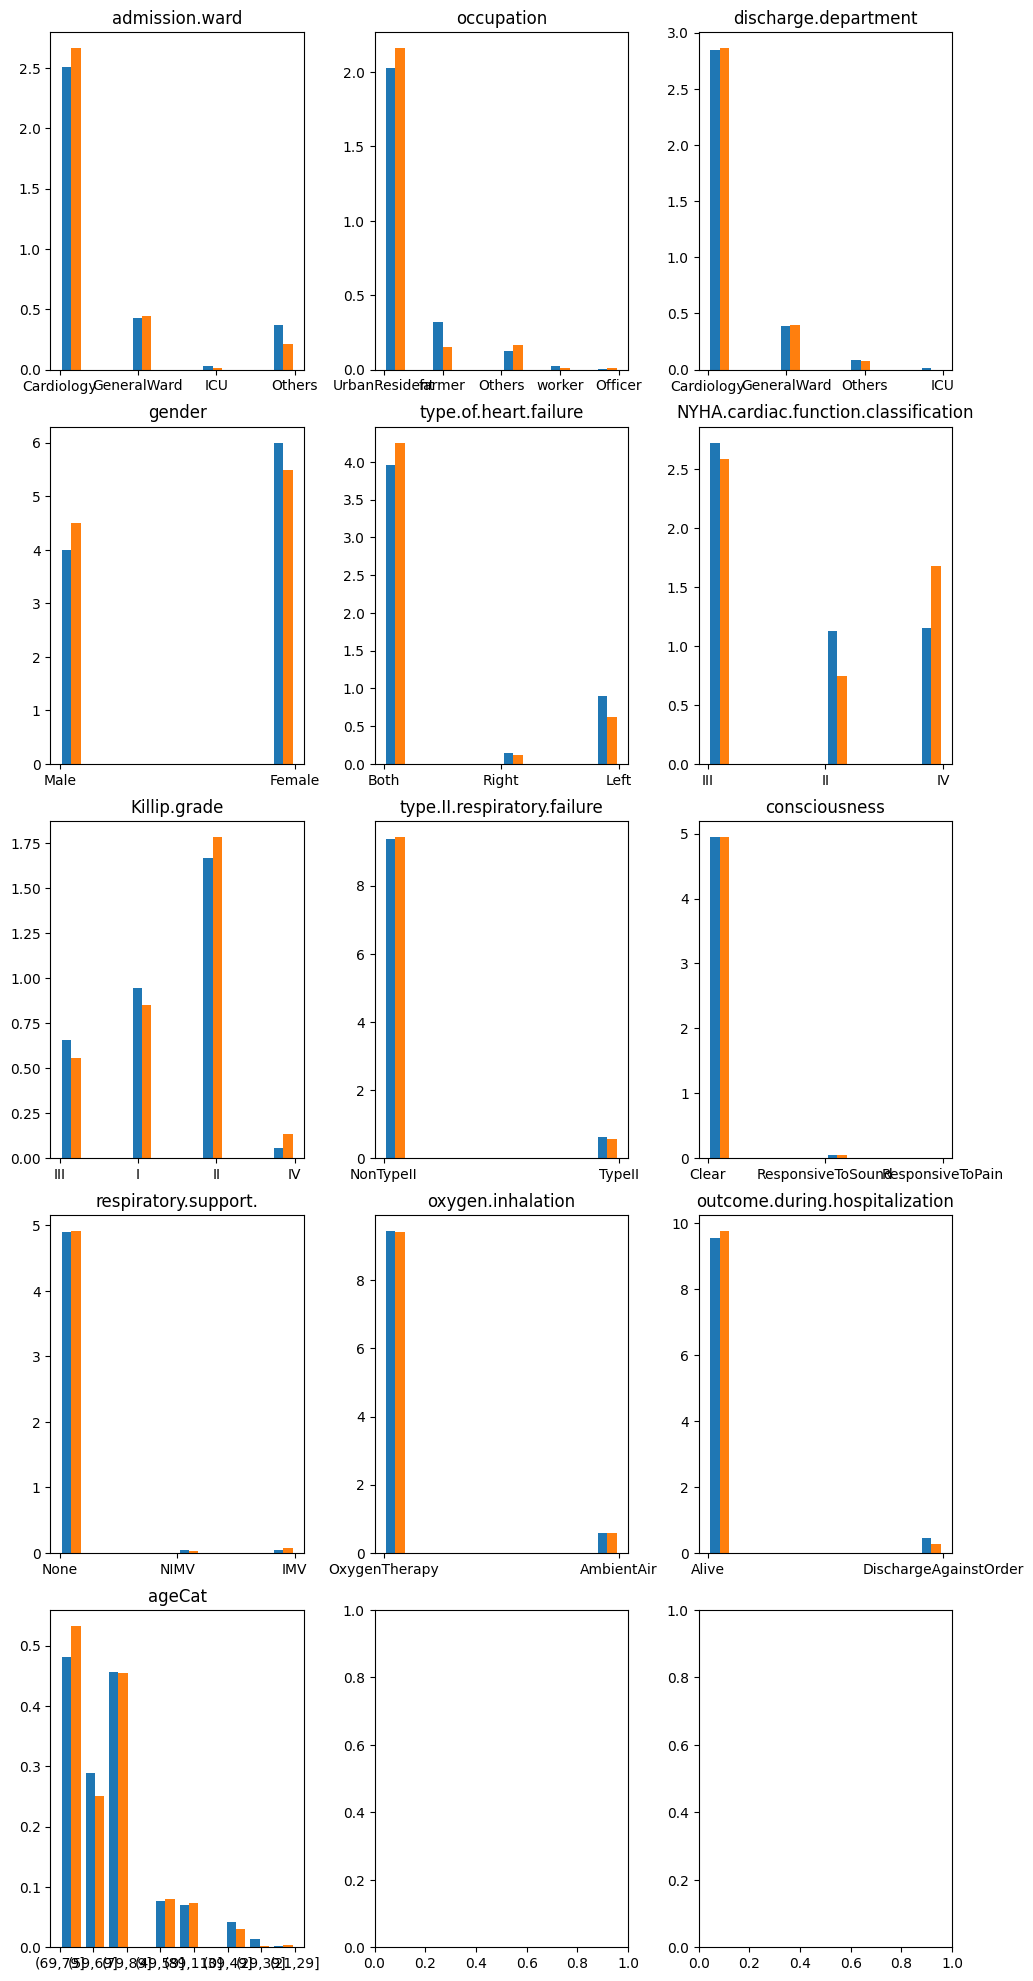

In [ ]:
# categorical features distribution plot
df_0=df_categorical[temp==0] # records wih target==0
df_1=df_categorical[temp==1] # records wih target==1


fig, axes = plt.subplots(5, 3,figsize=[10,20])
axes = axes.flatten()
fig.tight_layout(pad=2)

i=0
for x in df_categorical.columns:
    plt.sca(axes[i]) # set the current Axes
    plt.hist([df_0[x],df_1[x]],density=True)
    plt.title(x)
    i+=1
    if i > 12:
      break
plt.show()

### Numerical features Statistical Moments

In [ ]:
# numerical features variance plot
for ft in scaled_df.columns:
  print(ft,': ',scaled_df[ft].var())

In [ ]:
# numerical features skewness plot
for ft in scaled_df.columns:
  print(ft,': ',scaled_df[ft].skew())

In [ ]:
# numerical features kurtosis plot
for ft in scaled_df.columns:
  print(ft,': ',scaled_df[ft].kurtosis())

### Numerical features Boxplot

##### 0-22th feature

In [ ]:
temp1 = temp.apply(lambda x: 'yes' if x==1.0 else 'no')

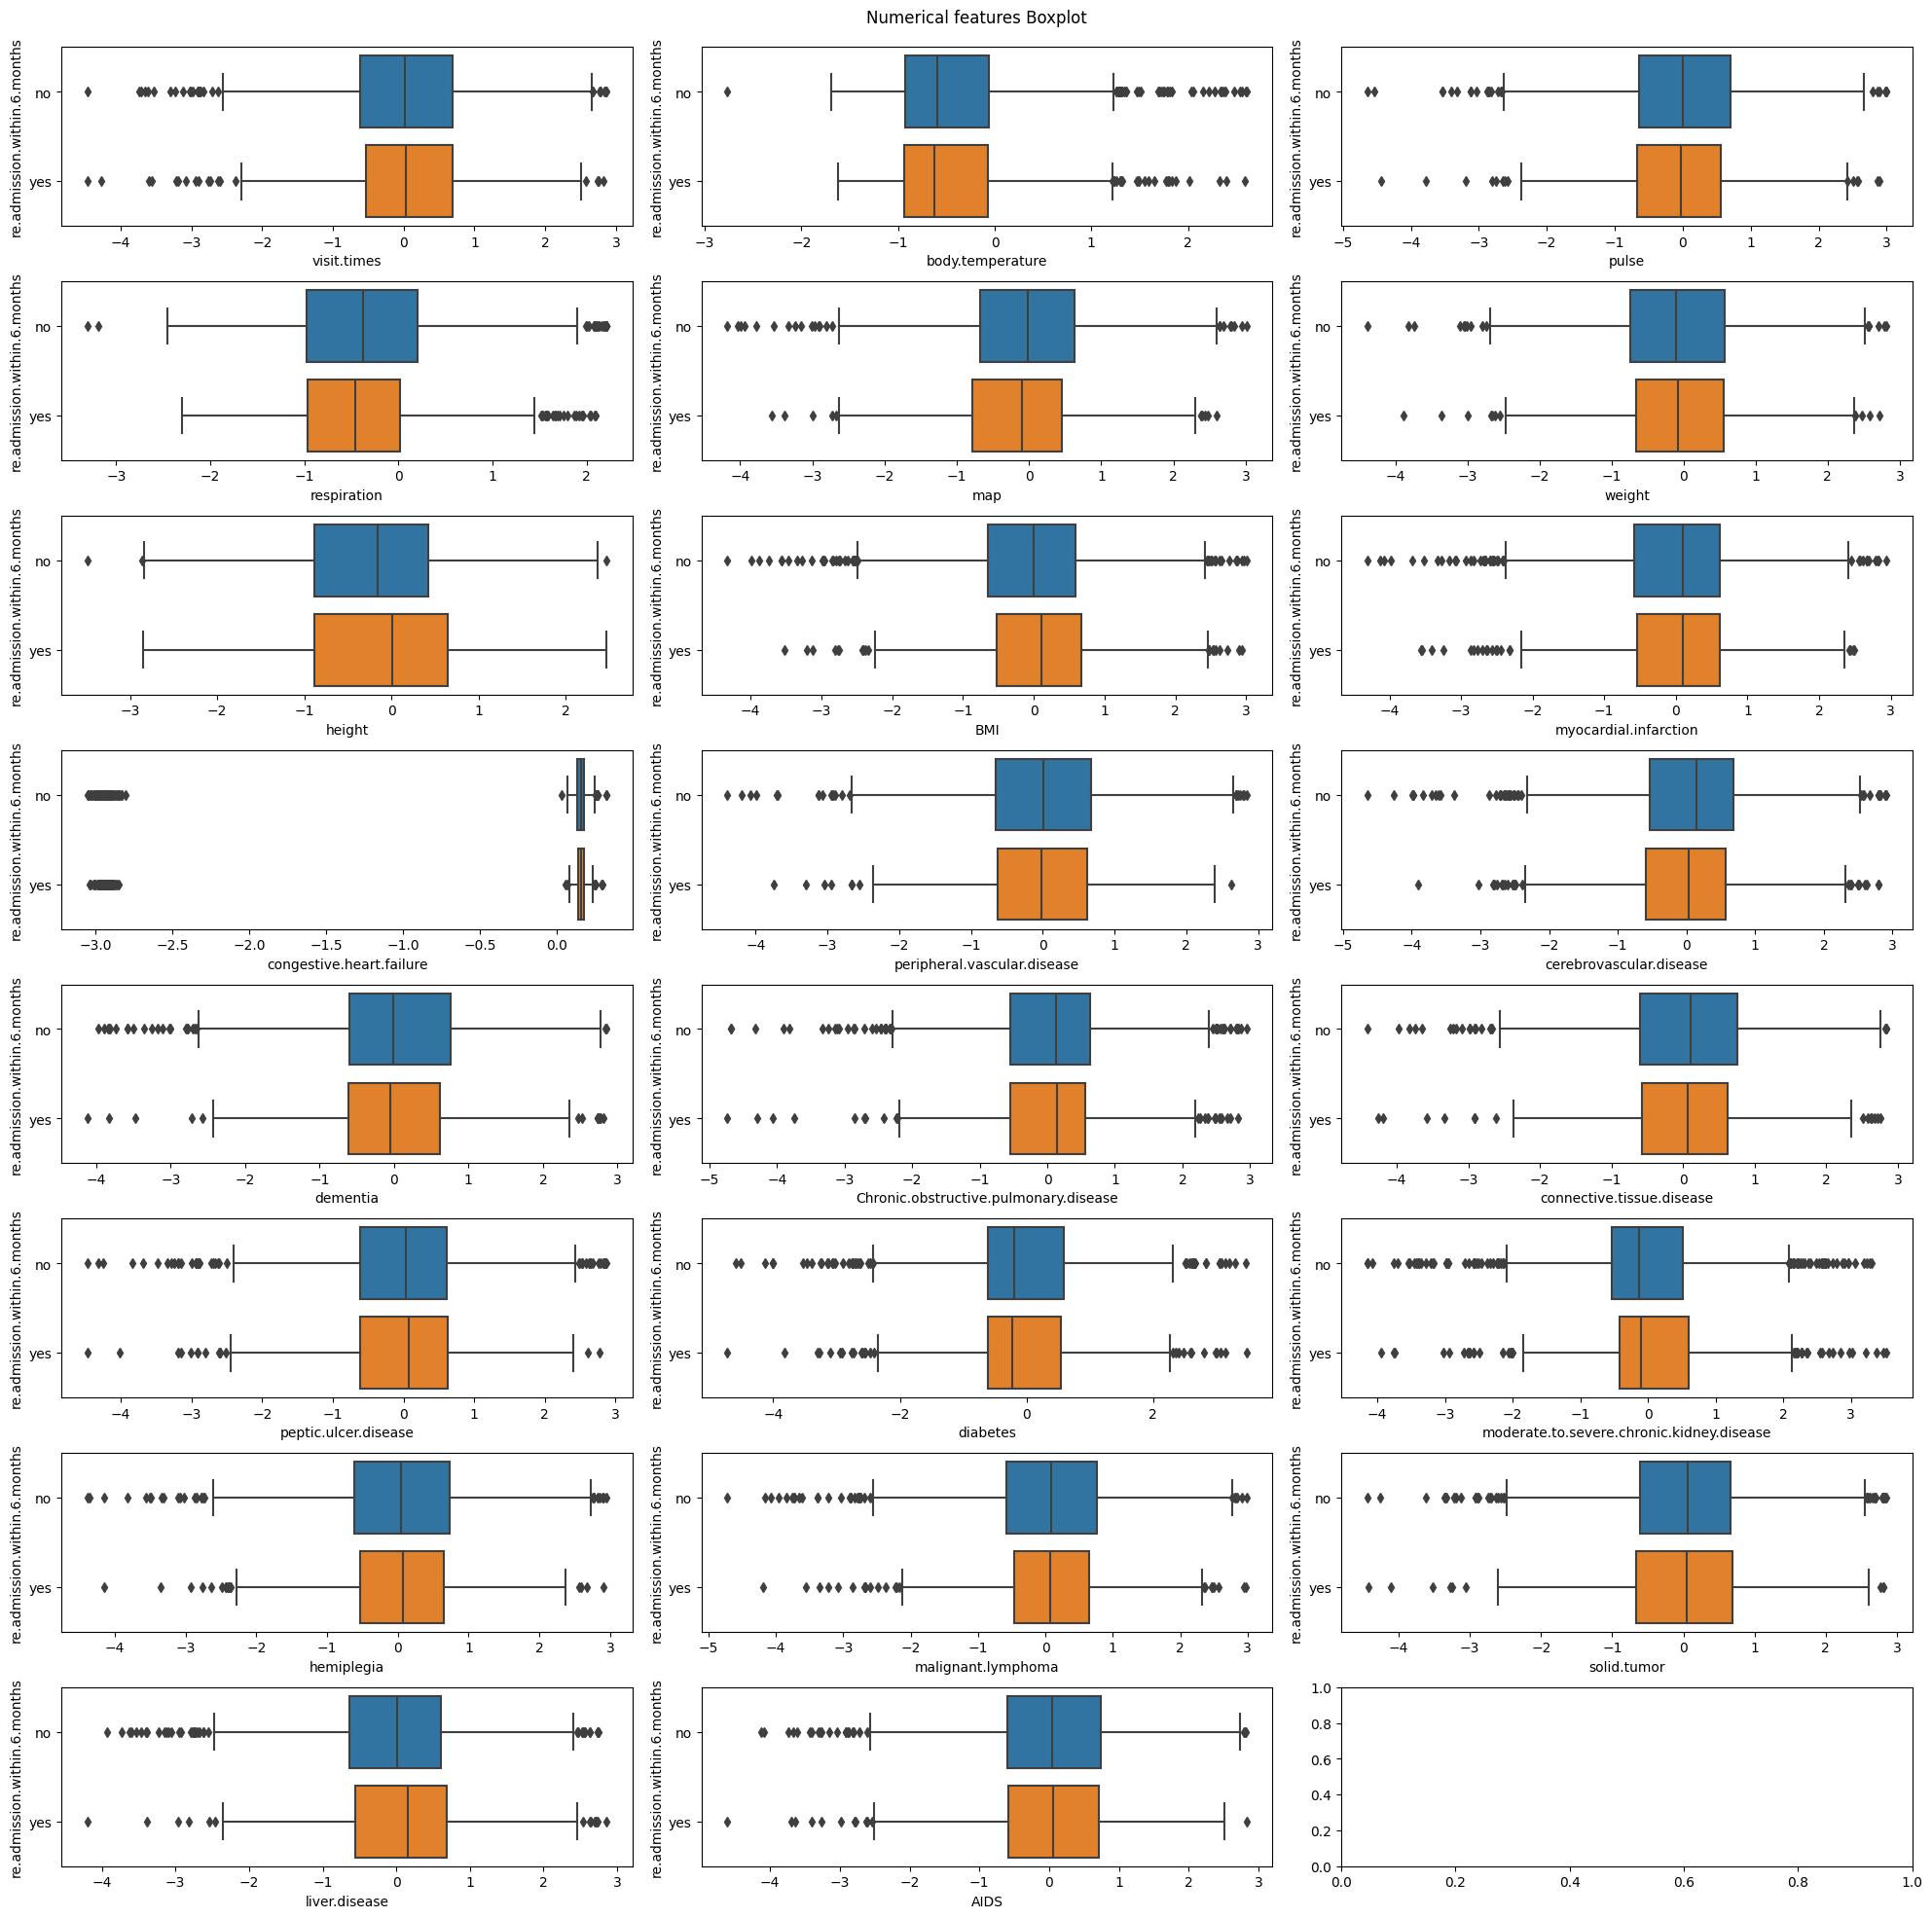

In [ ]:
# box plot 
temp_df_1 = pd.concat([scaled_df.iloc[:,0:23], temp1], axis = 1)
fig, axes = plt.subplots(8,3, figsize=(20, 20))
fig.suptitle('Numerical features Boxplot')
axes = axes.flatten()
fig.tight_layout(pad=2)
count = 0;
for ft in temp_df_1.columns:
  if ft != 're.admission.within.6.months':
    plt.sca(axes[count])
    sns.boxplot(data=temp_df_1, x=ft, y='re.admission.within.6.months')
    count +=1
plt.show()

##### 23-45th feature

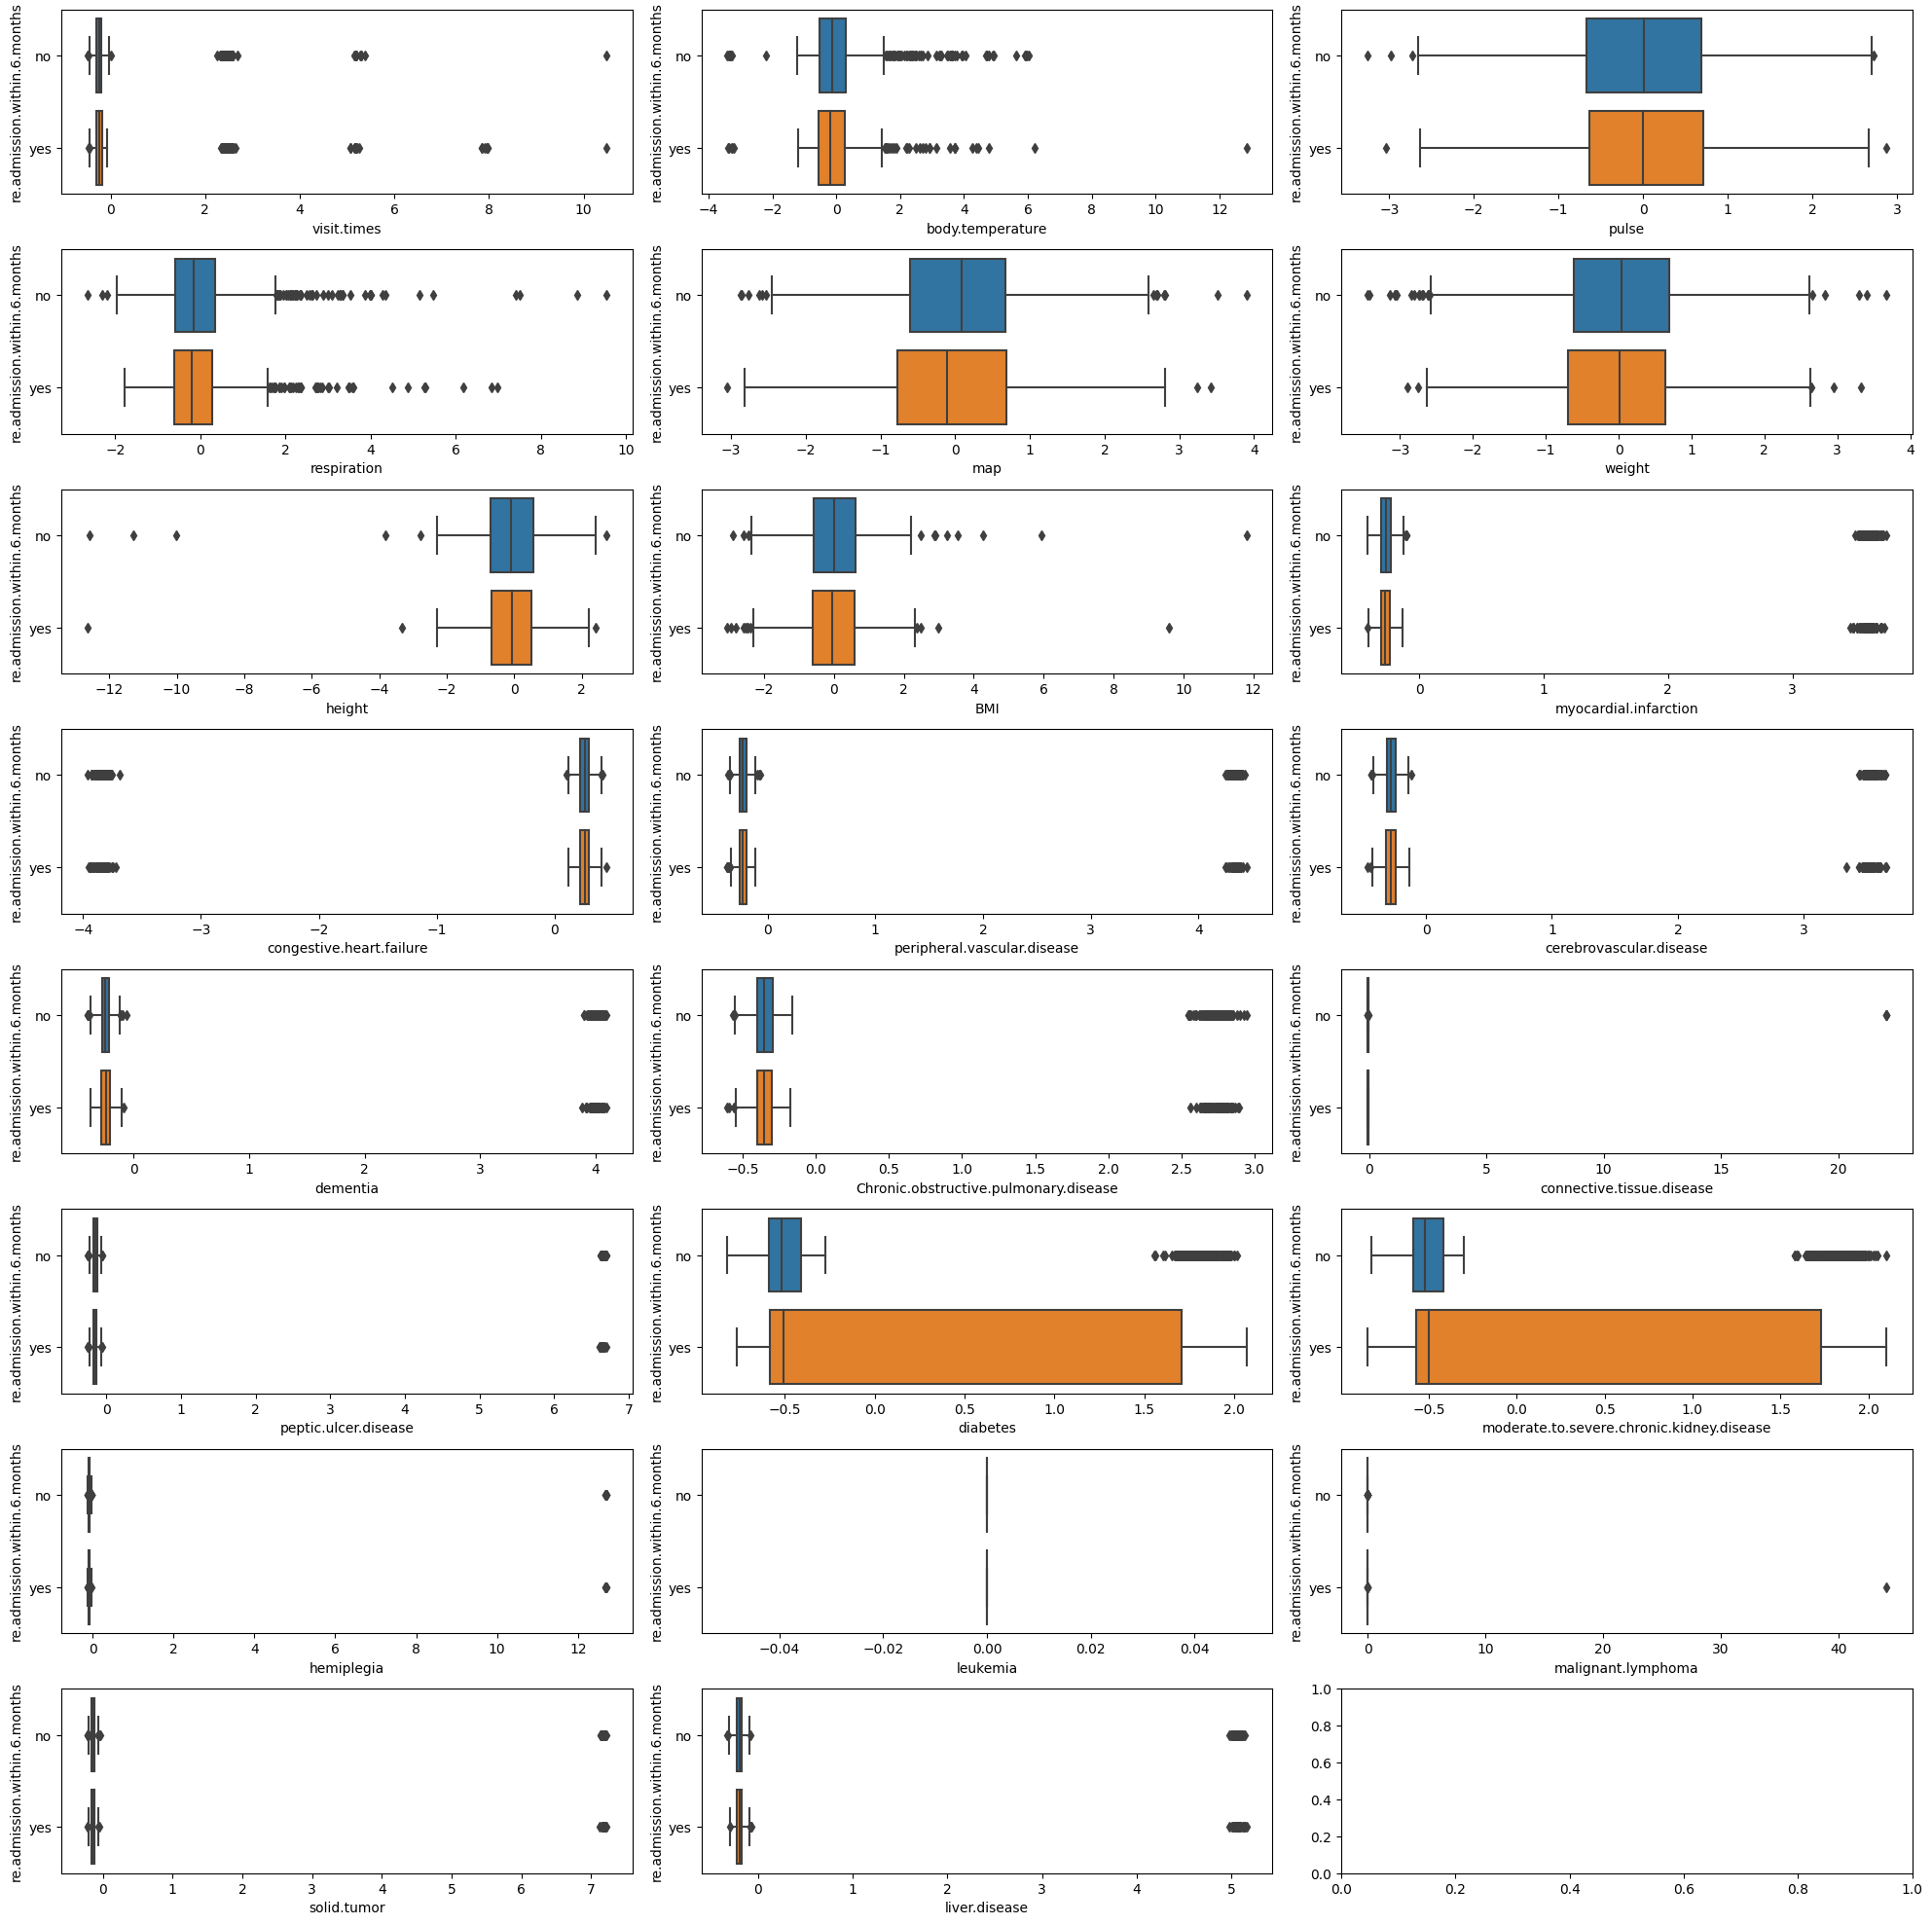

In [ ]:
# box plot 
temp_df = pd.concat([scaled_df.iloc[:,23:46], temp1], axis = 1)
fig.suptitle('Numerical features Boxplot')
fig, axes = plt.subplots(8,3, figsize=(20, 20))
axes = axes.flatten()
fig.tight_layout(pad=2)
count = 0;
for ft in temp_df_1.columns:
  if ft != 're.admission.within.6.months':
    plt.sca(axes[count])
    sns.boxplot(data=temp_df_1, x=ft, y='re.admission.within.6.months')
    count +=1
plt.show()

##### 46-66th feature

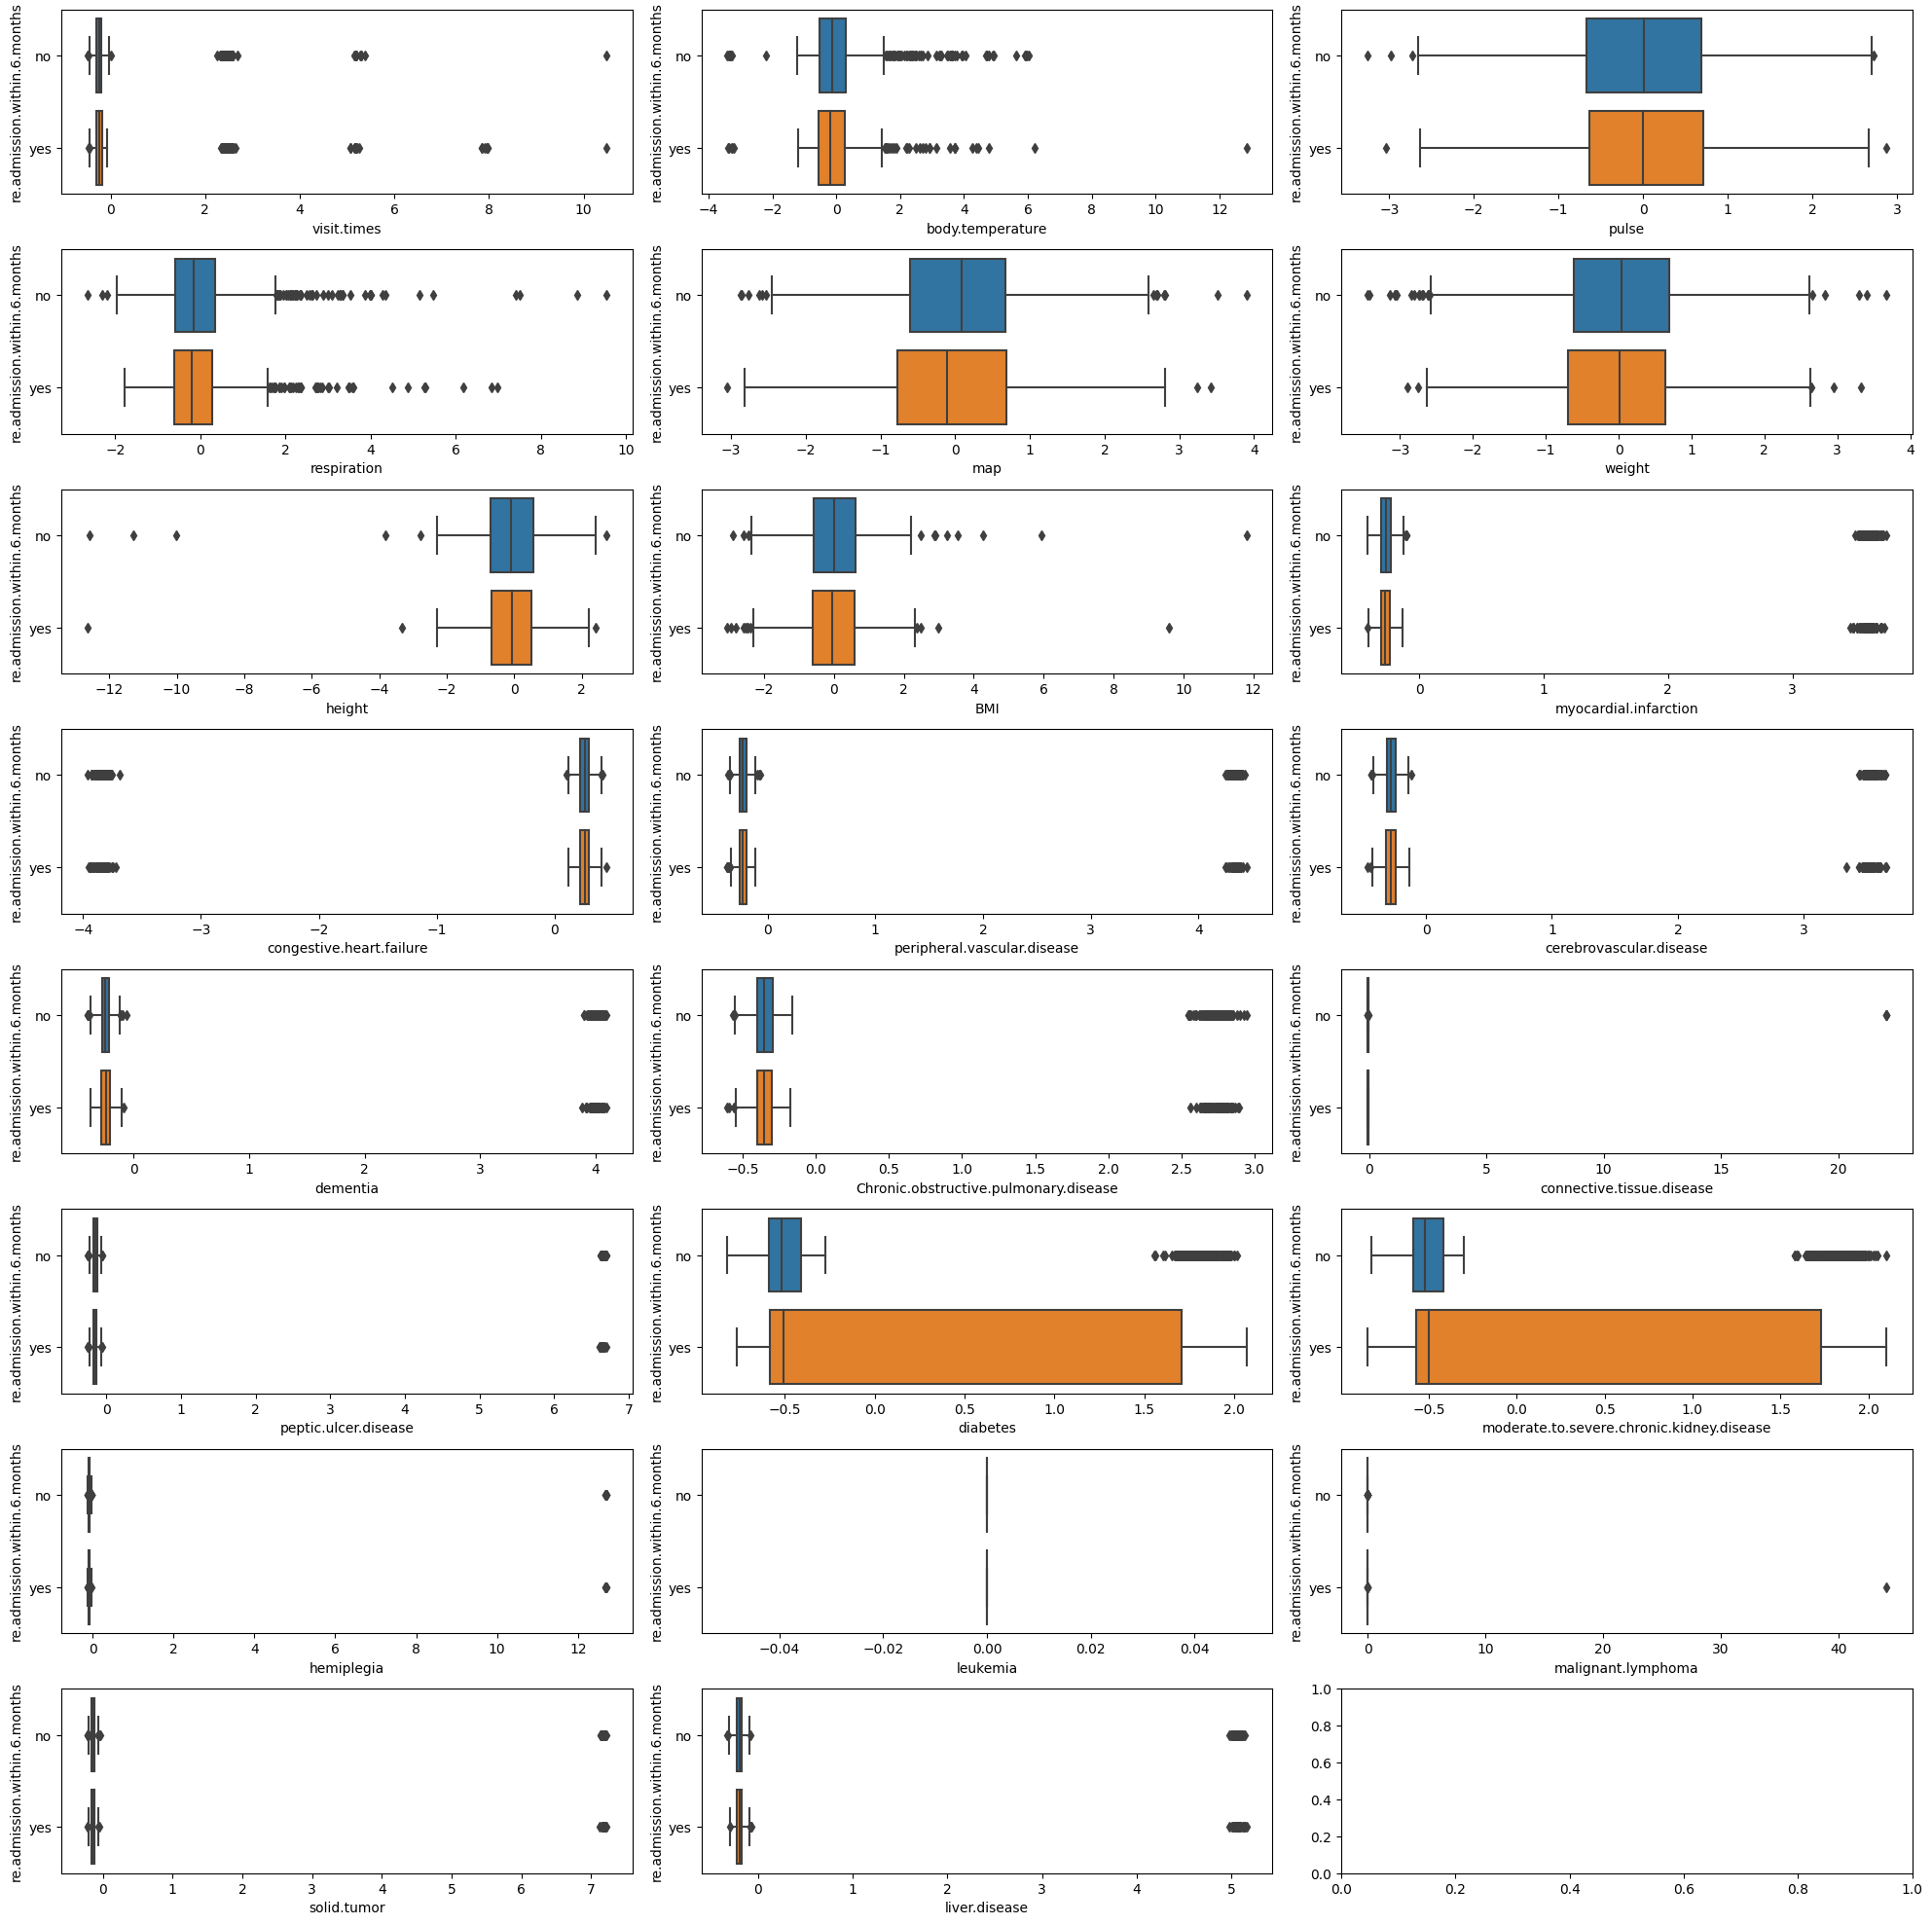

In [ ]:
# box plot 
temp_df = pd.concat([scaled_df.iloc[:,46:67], temp1], axis = 1)
fig.suptitle('Numerical features Boxplot')
fig, axes = plt.subplots(8,3, figsize=(20, 20))
axes = axes.flatten()
fig.tight_layout(pad=2)
count = 0;
for ft in temp_df_1.columns:
  if ft != 're.admission.within.6.months':
    plt.sca(axes[count])
    sns.boxplot(data=temp_df_1, x=ft, y='re.admission.within.6.months')
    count +=1
plt.show()

### Numerical features Histplot
In order to use gaussian_kde algorithm to extract the continuous density curve, it is necessaty to use the non-scaled data, since the scaled one has a singular covariance matrix

##### 0-22th feature

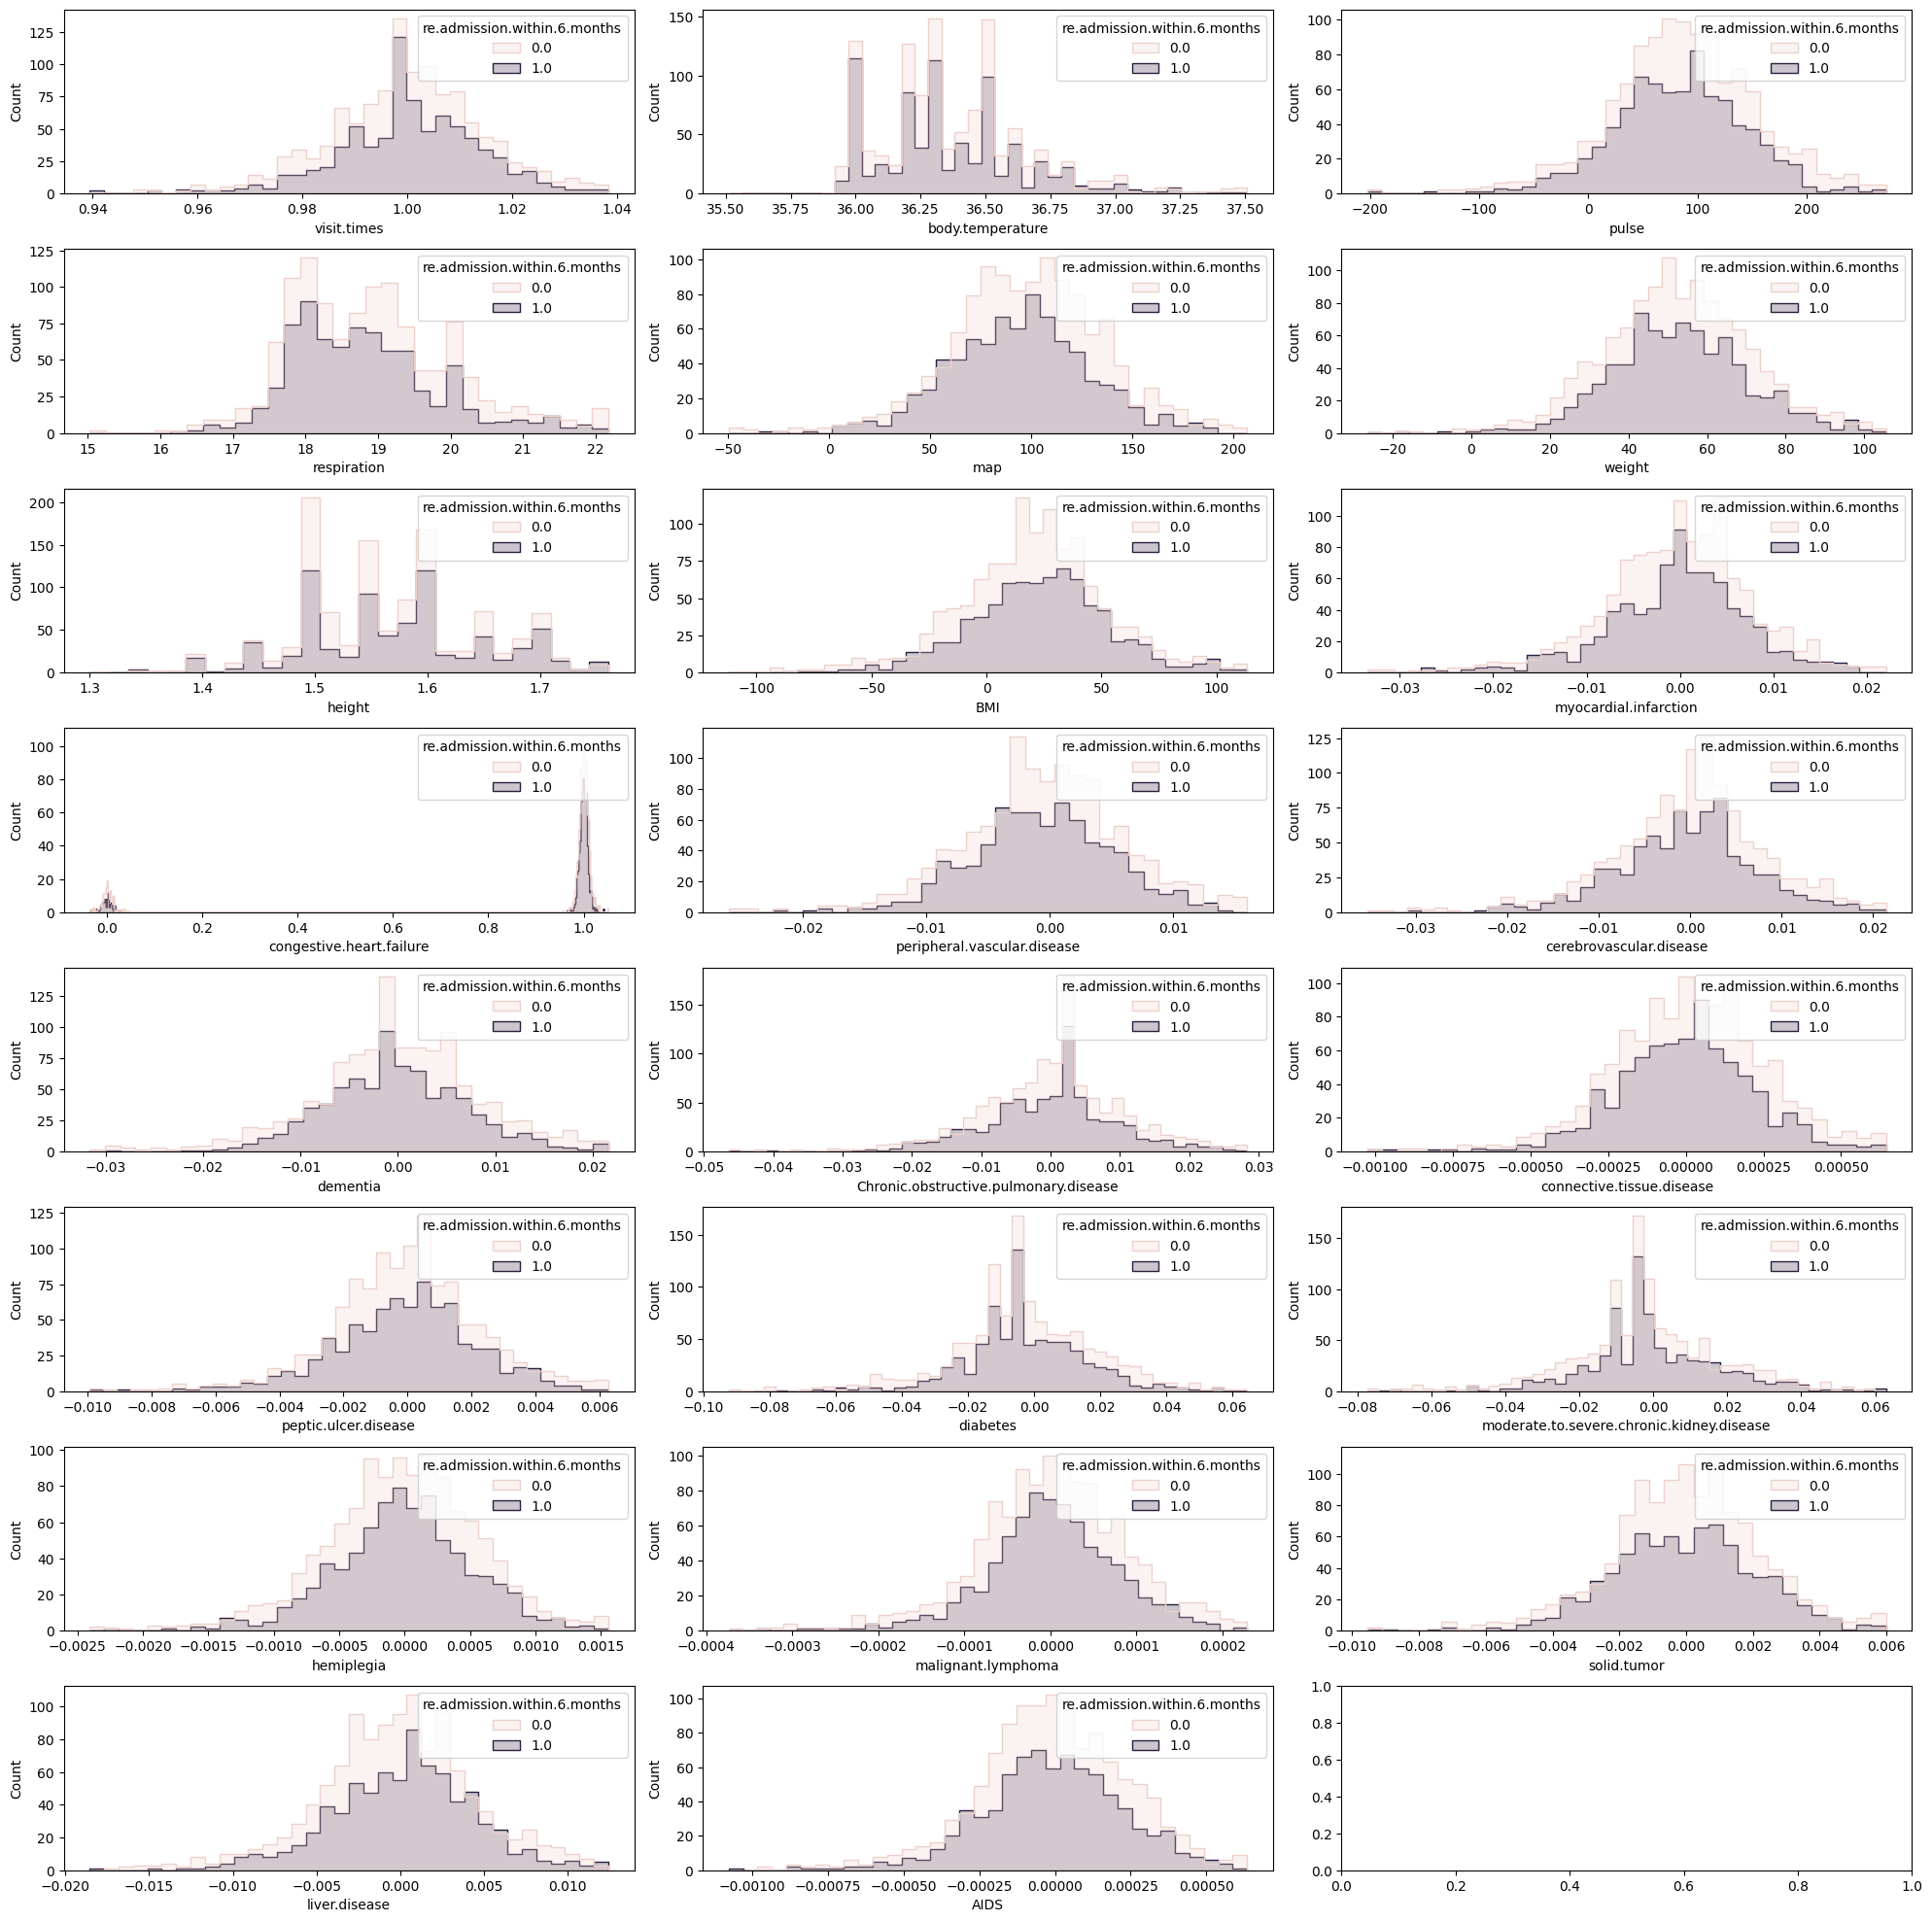

In [ ]:
# distribution plots
temp_df_1 = df_numerical.iloc[:,0:23]
fig, axes = plt.subplots(8,3, figsize=(20, 20))
axes = axes.flatten()
fig.tight_layout(pad=2)
count = 0;
for ft in temp_df_1.columns: 
  plt.sca(axes[count])
  sns.histplot(x=temp_df_1[ft], hue=temp, element="step")
  count += 1
plt.show()

##### 23-45th feature

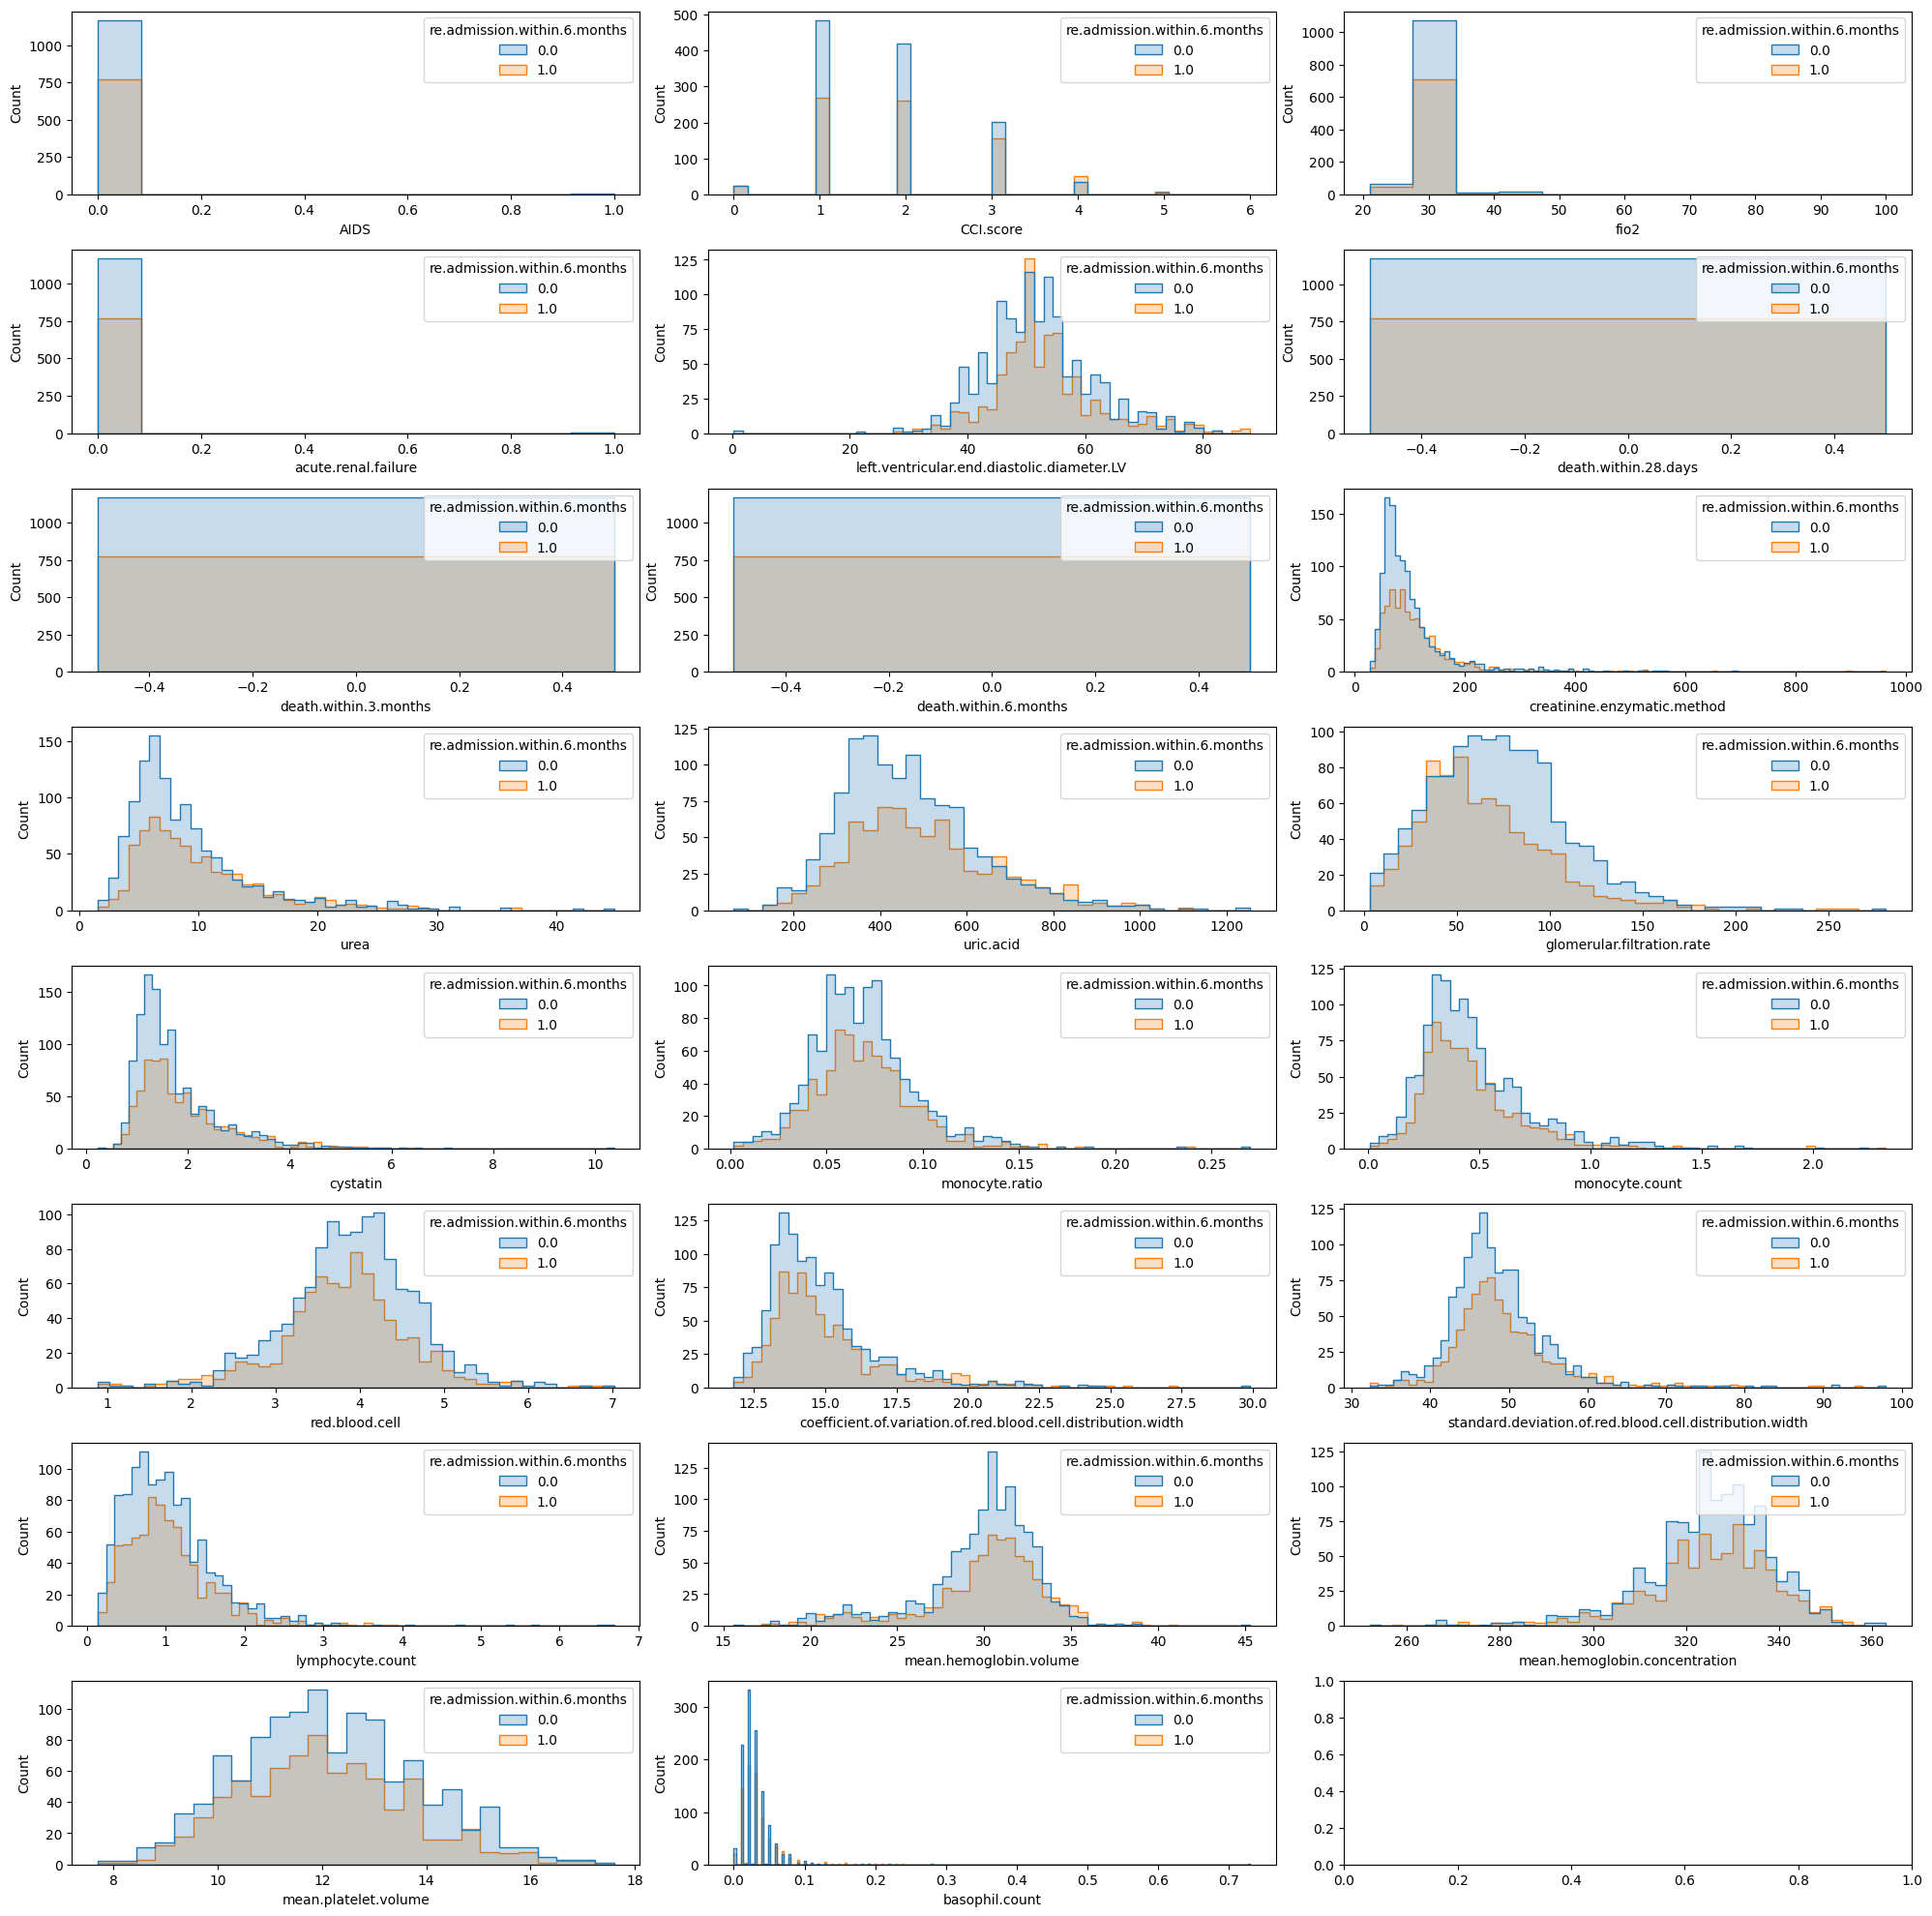

In [ ]:
# distribution plots
temp_df_1 = df_numerical.iloc[:,23:46]
fig, axes = plt.subplots(8,3, figsize=(20, 20))
axes = axes.flatten()
fig.tight_layout(pad=2)
count = 0;
for ft in temp_df_1.columns: 
  plt.sca(axes[count])
  sns.histplot(x=temp_df_1[ft], hue=temp, element="step")
  count += 1
plt.show()

##### 46-66th feature

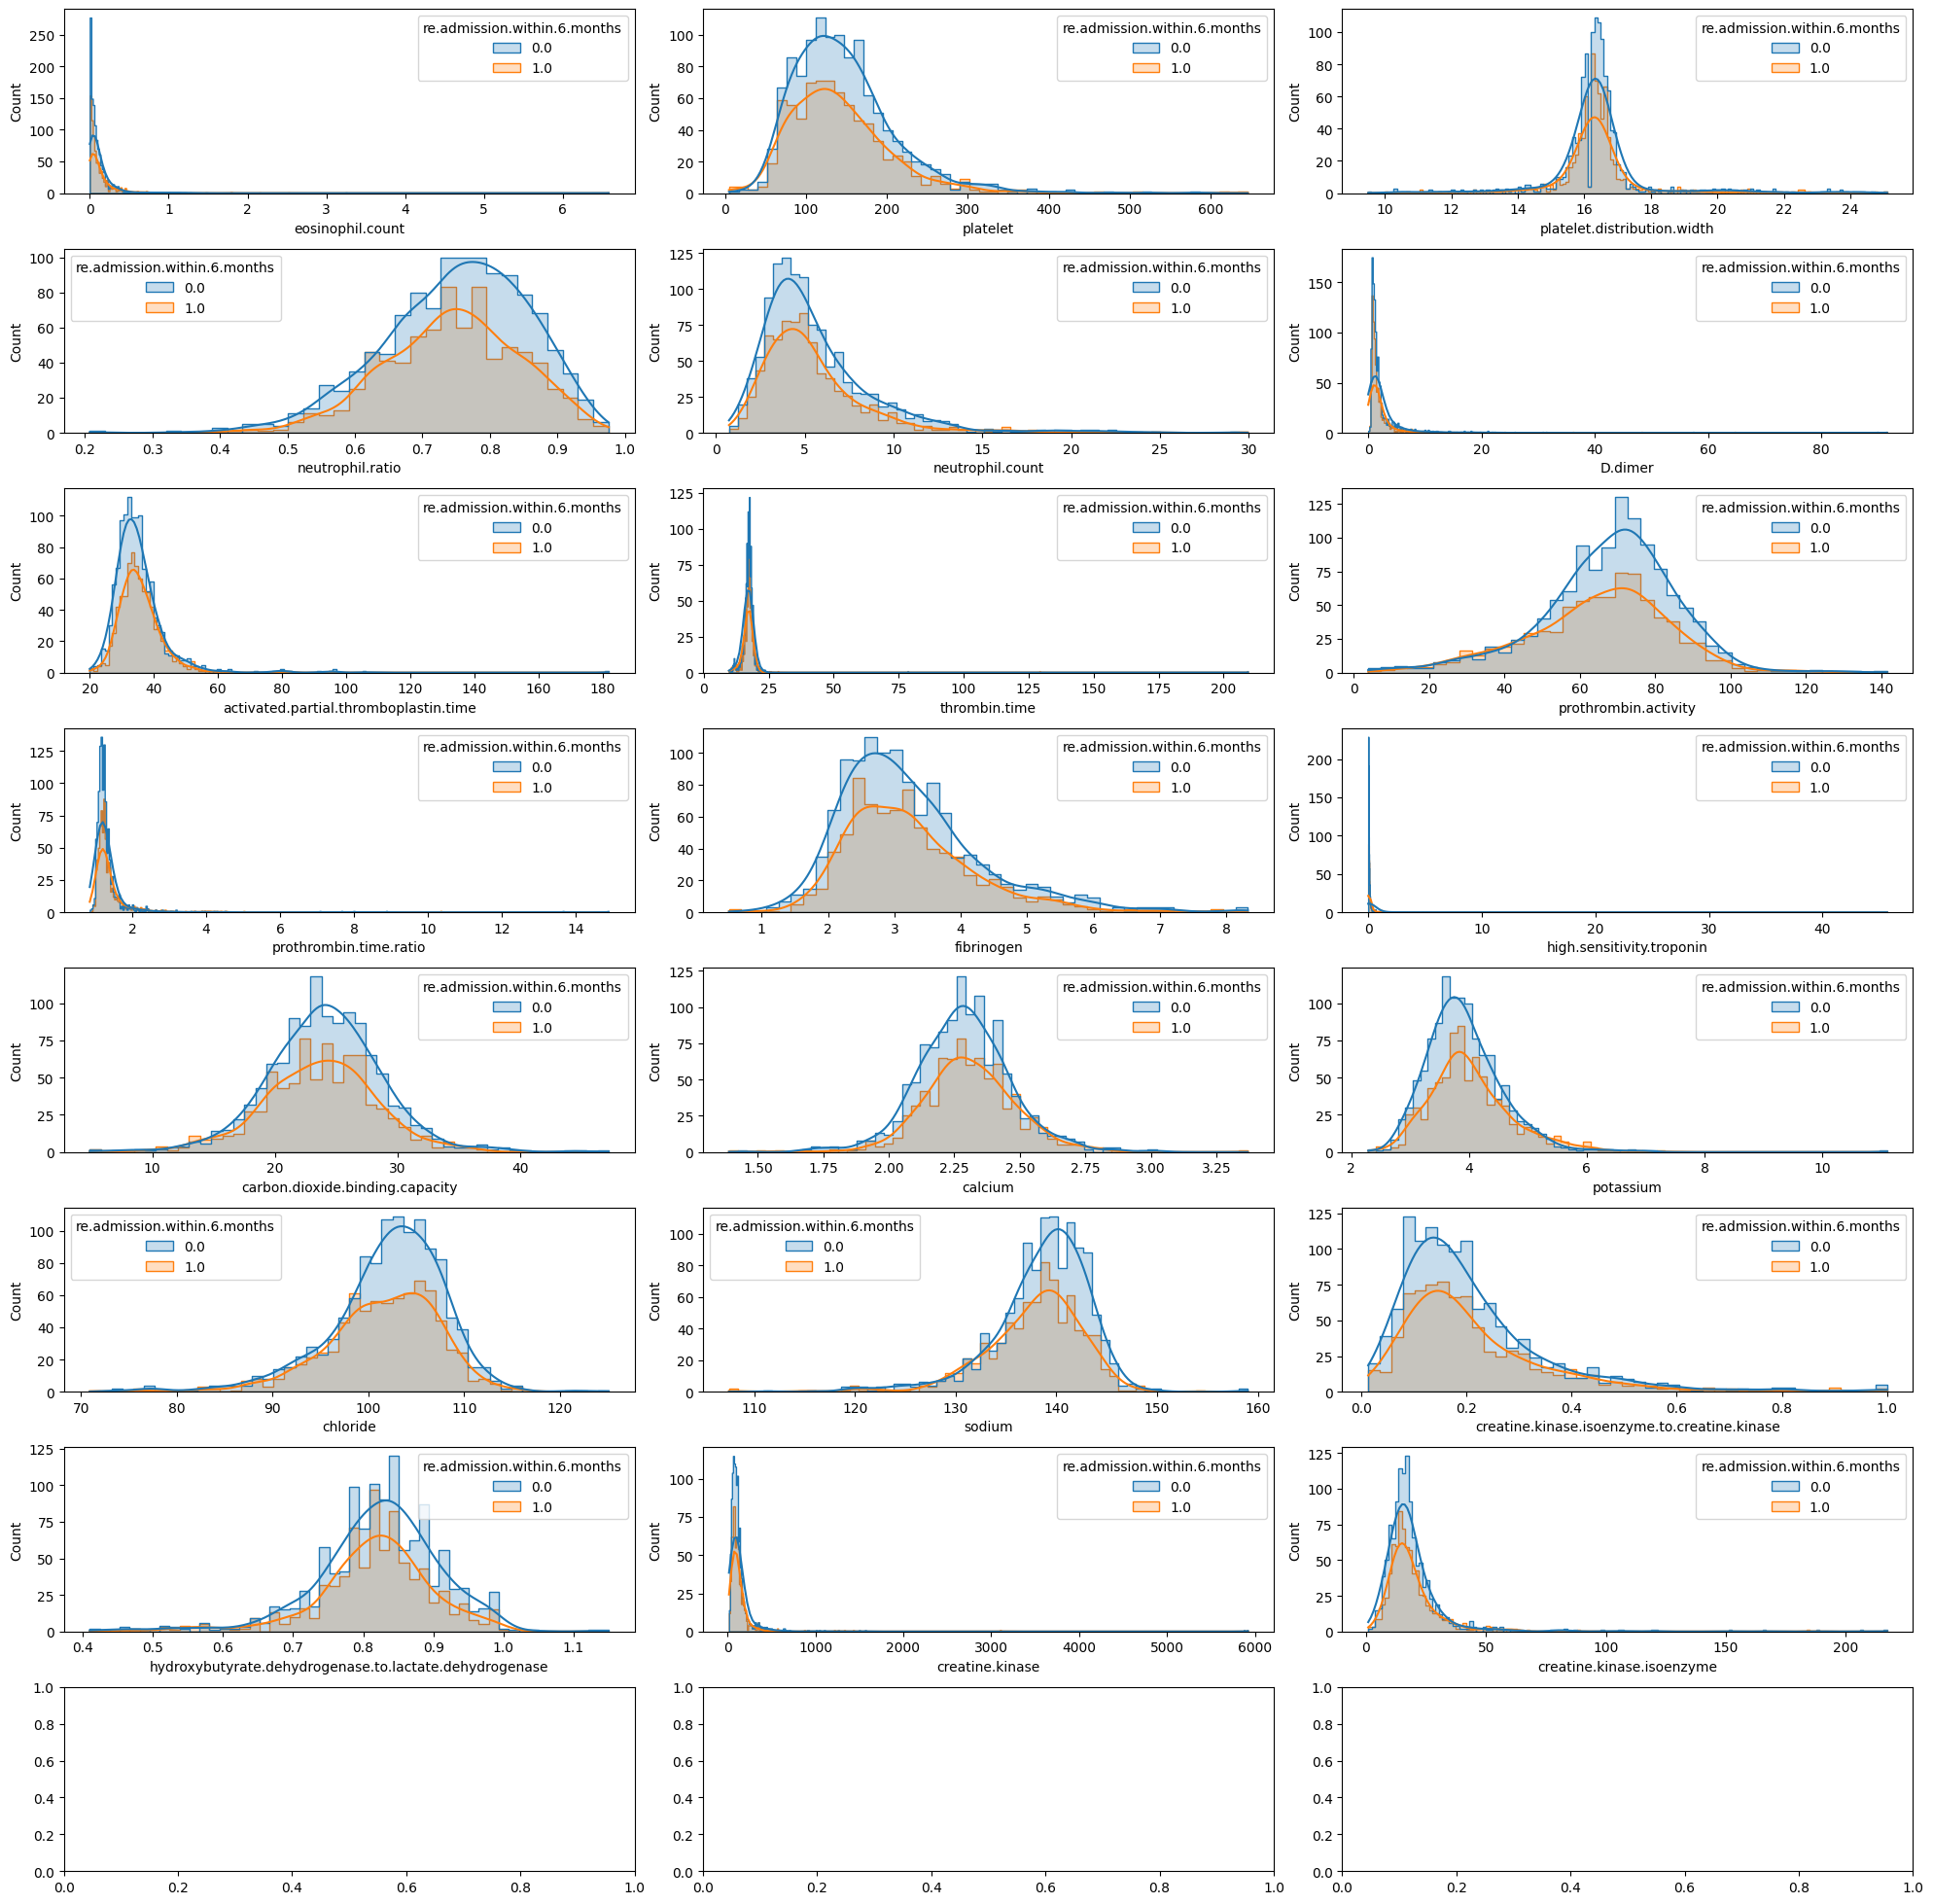

In [ ]:
# distribution plots
temp_df_1 = df_numerical.iloc[:,46:67]
fig, axes = plt.subplots(8,3, figsize=(20, 20))
axes = axes.flatten()
fig.tight_layout(pad=2)
count = 0;
for ft in temp_df_1.columns: 
  plt.sca(axes[count])
  sns.histplot(x=temp_df_1[ft], hue=temp, element="step",kde=True)
  count += 1
plt.show()

### Numerical features QQ-plot

##### 0-22th feature

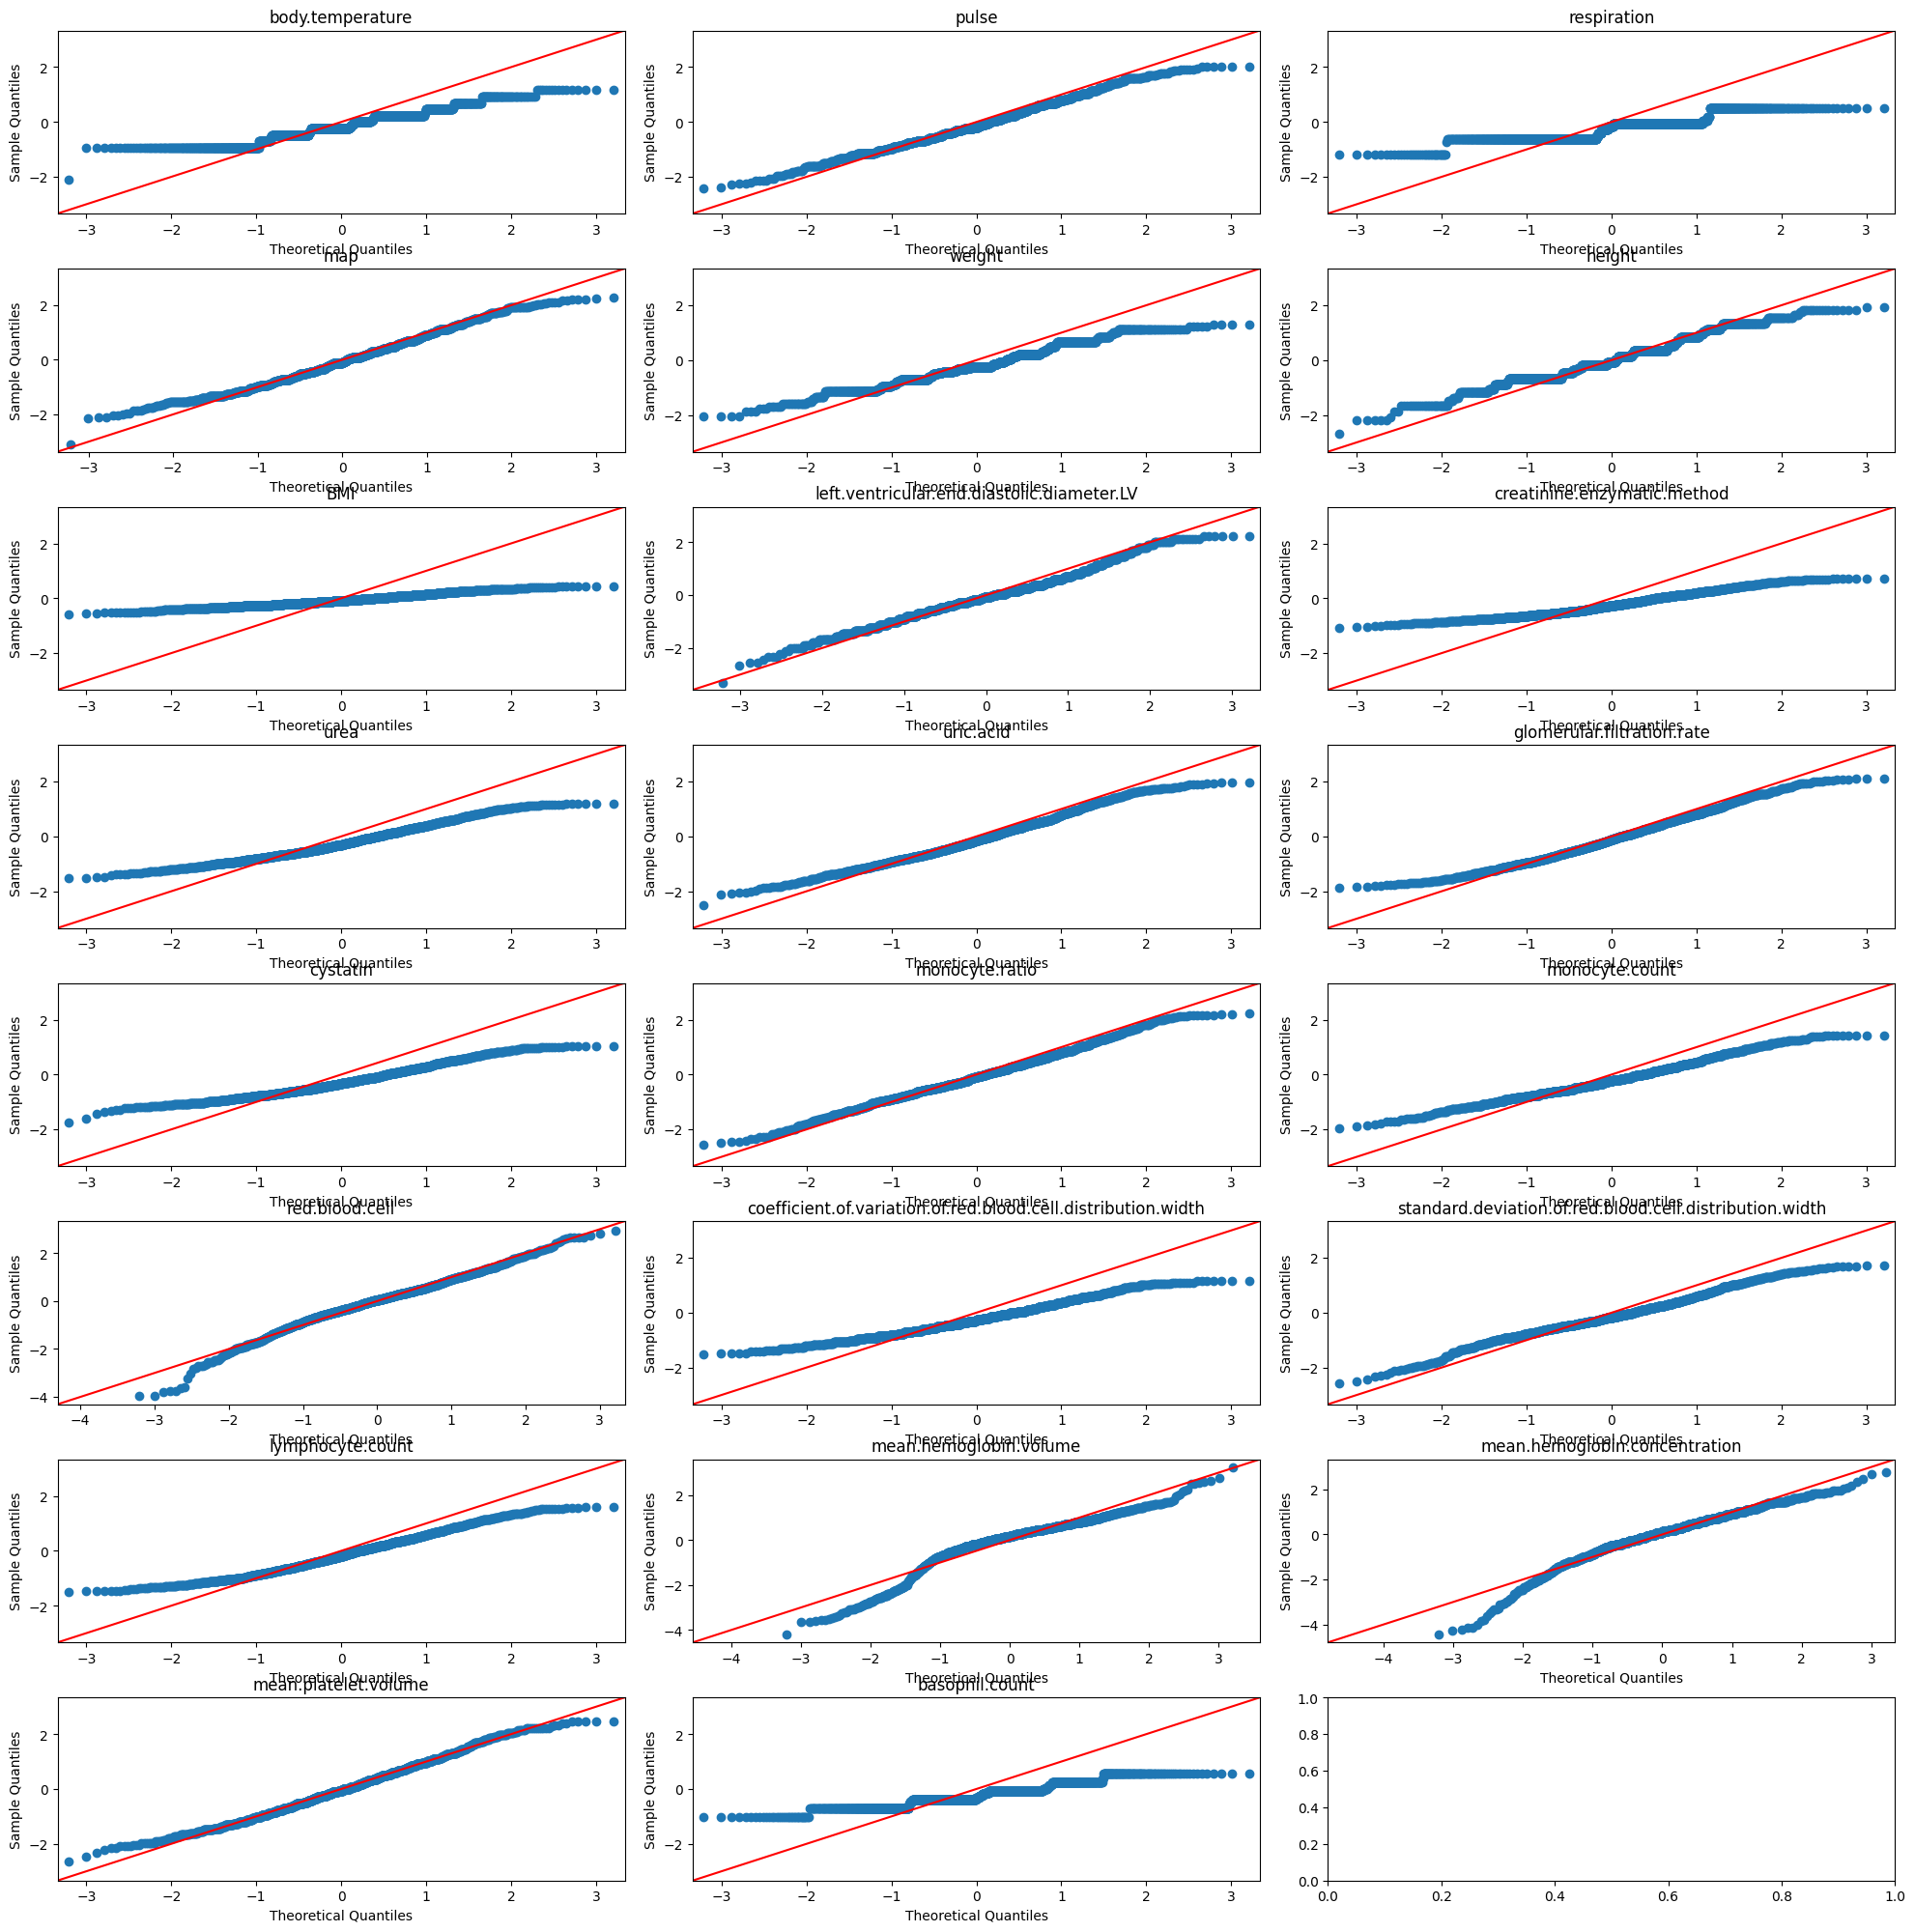

In [ ]:
# QQ-plot
temp_df_1 = scaled_df.iloc[:,0:23]
fig, axes = plt.subplots(8,3, figsize=(20, 20))
axes = axes.flatten()
fig.tight_layout(pad=2)
count = 0;
for ft in temp_df_1.columns: 
  plt.sca(axes[count])
  sm.qqplot(temp_df_1[ft], line ='45', ax = axes[count])
  plt.title(ft)
  count += 1
plt.show()

##### 23-45th feature




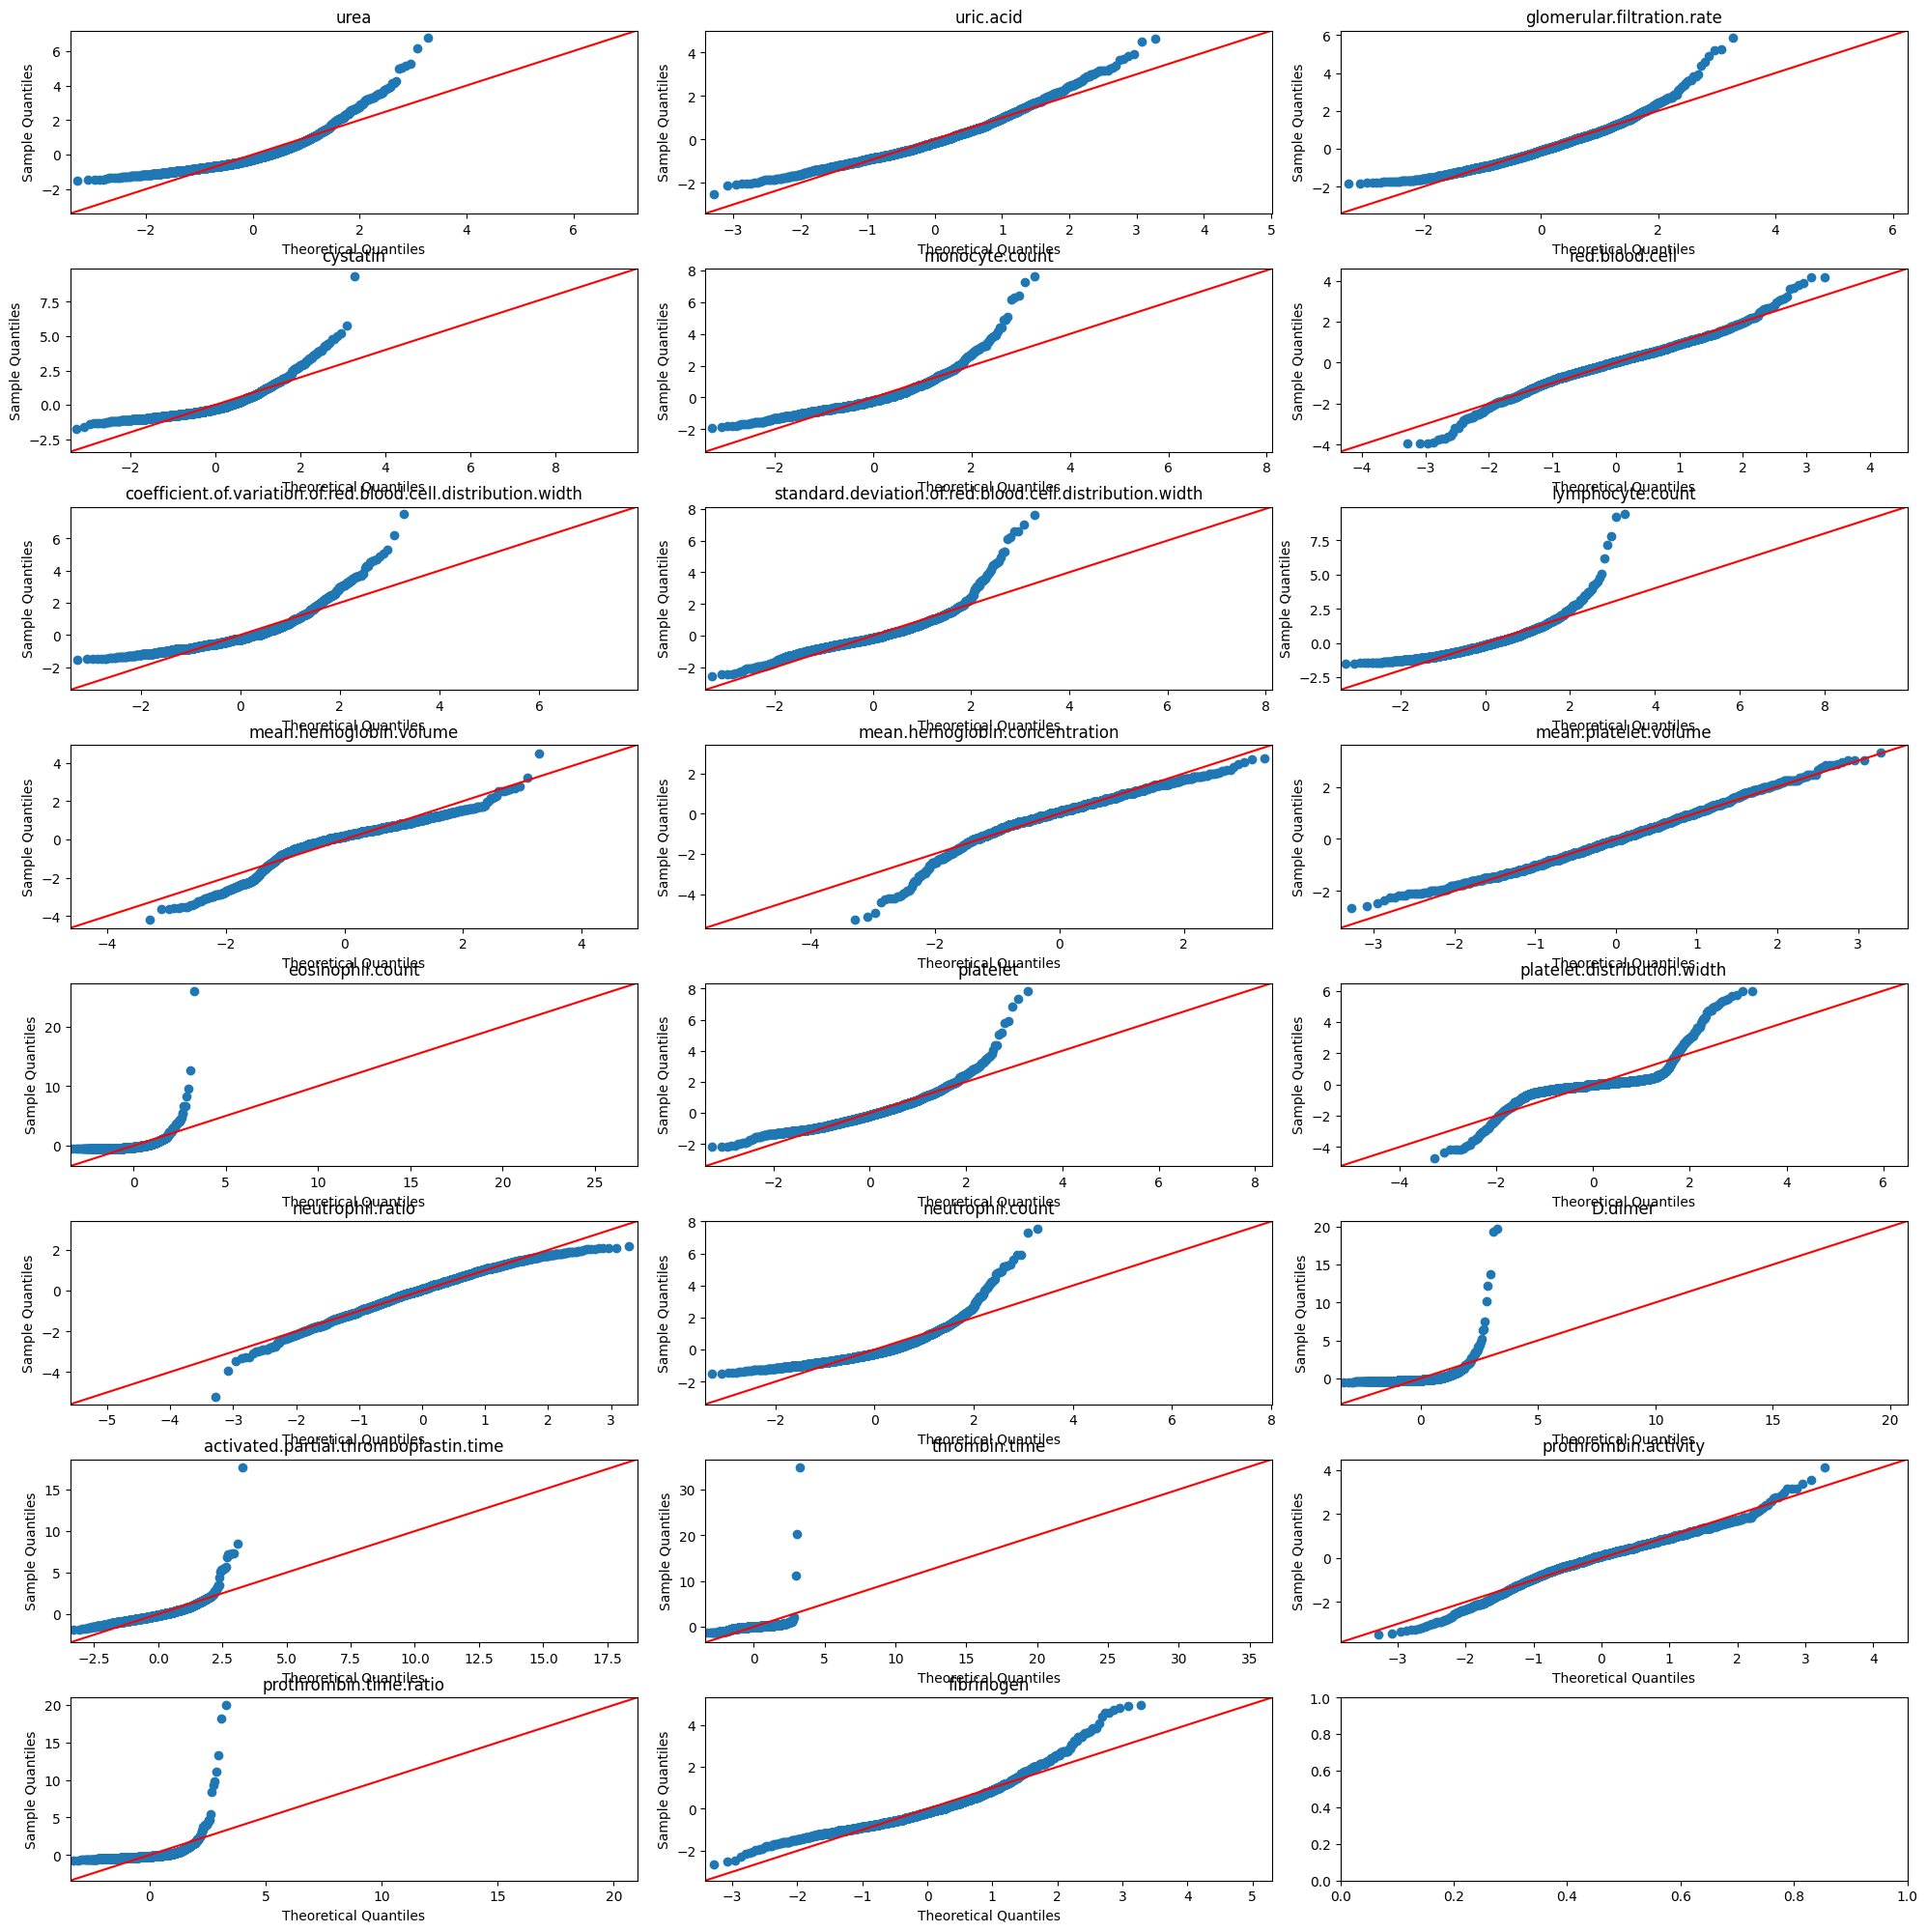

In [ ]:
# QQ-plot
temp_df_1 = scaled_df.iloc[:,23:46]
fig, axes = plt.subplots(8,3, figsize=(20, 20))
axes = axes.flatten()
fig.tight_layout(pad=2)
count = 0;
for ft in temp_df_1.columns: 
  plt.sca(axes[count])
  sm.qqplot(temp_df_1[ft], line ='45', ax = axes[count])
  plt.title(ft)
  count += 1
plt.show()

##### 46-66th feature

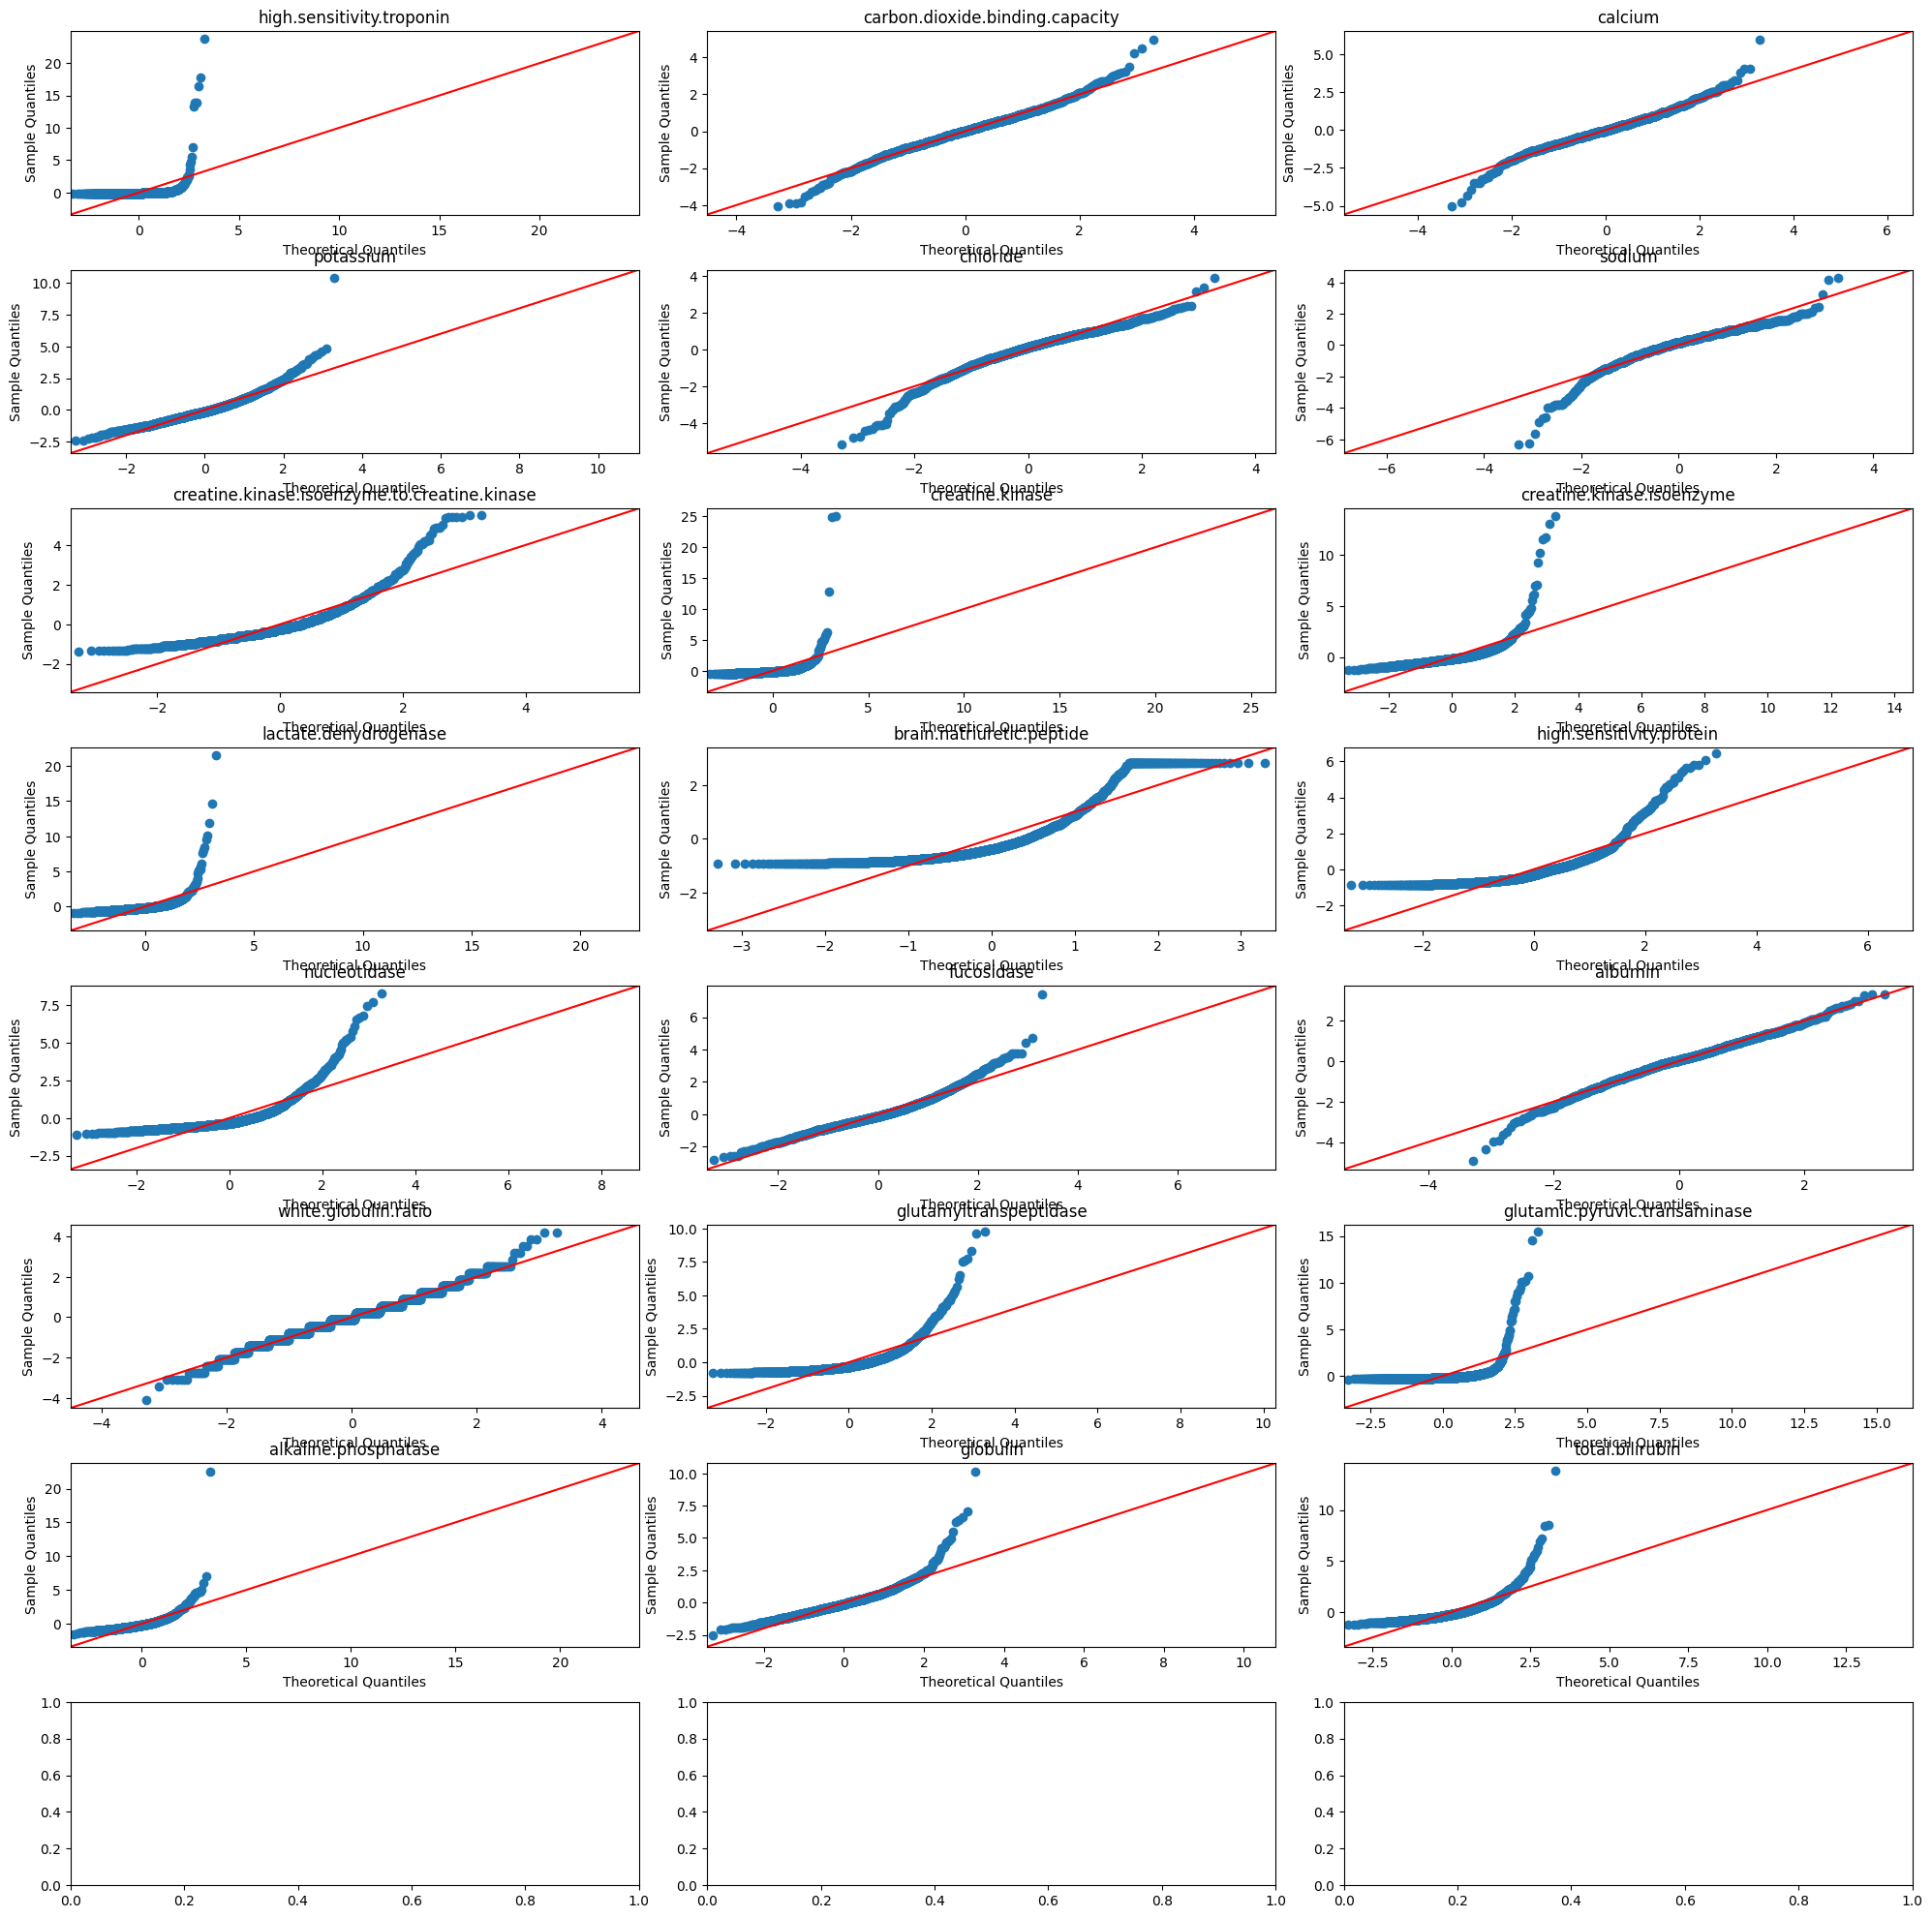

In [ ]:
# QQ-plot
temp_df_1 = scaled_df.iloc[:,46:67]
fig, axes = plt.subplots(8,3, figsize=(20, 20))
axes = axes.flatten()
fig.tight_layout(pad=2)
count = 0;
for ft in temp_df_1.columns: 
  plt.sca(axes[count])
  sm.qqplot(temp_df_1[ft], line ='45', ax = axes[count])
  plt.title(ft)
  count += 1
plt.show()

### Numerical features Correlation

##### 0-22th feature

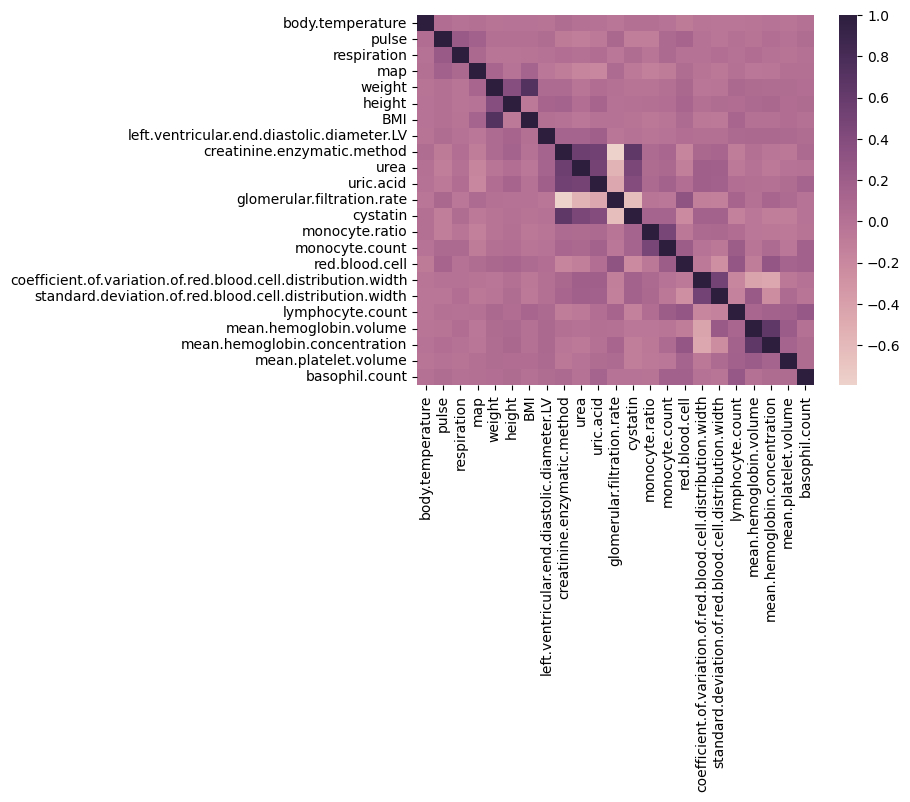

In [ ]:
temp_df_1 = scaled_df.iloc[:,0:23]
sns.heatmap(temp_df_1.corr(), annot=False,  cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

##### 23-45th feature

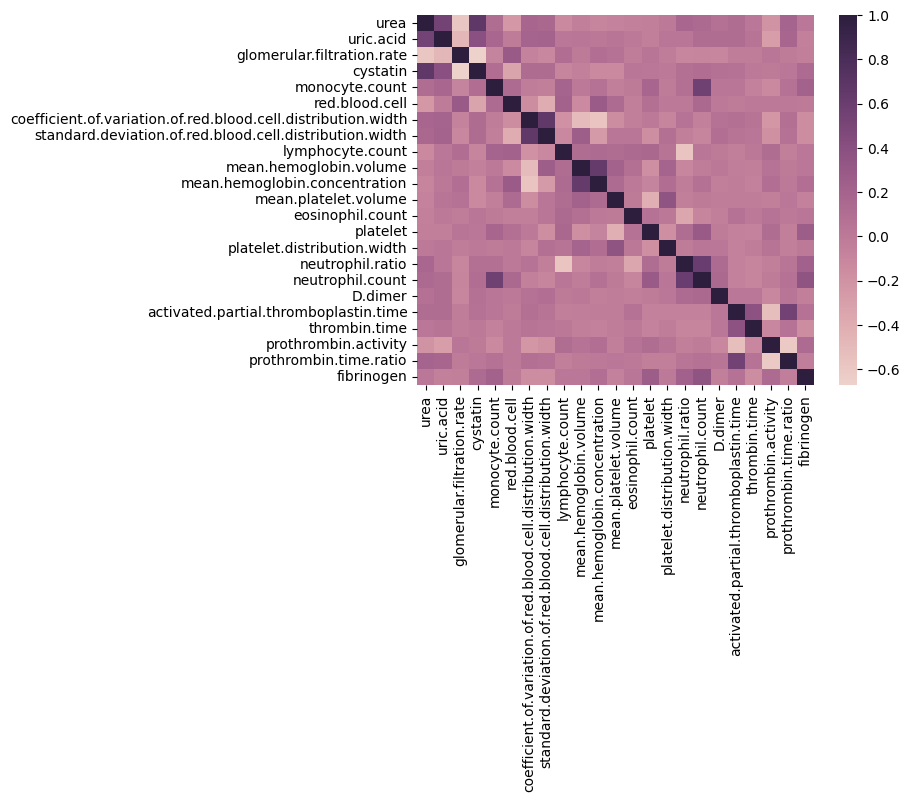

In [ ]:
temp_df_1 = scaled_df.iloc[:,23:46]
sns.heatmap(temp_df_1.corr(), annot=False,  cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

##### 46-66th feature

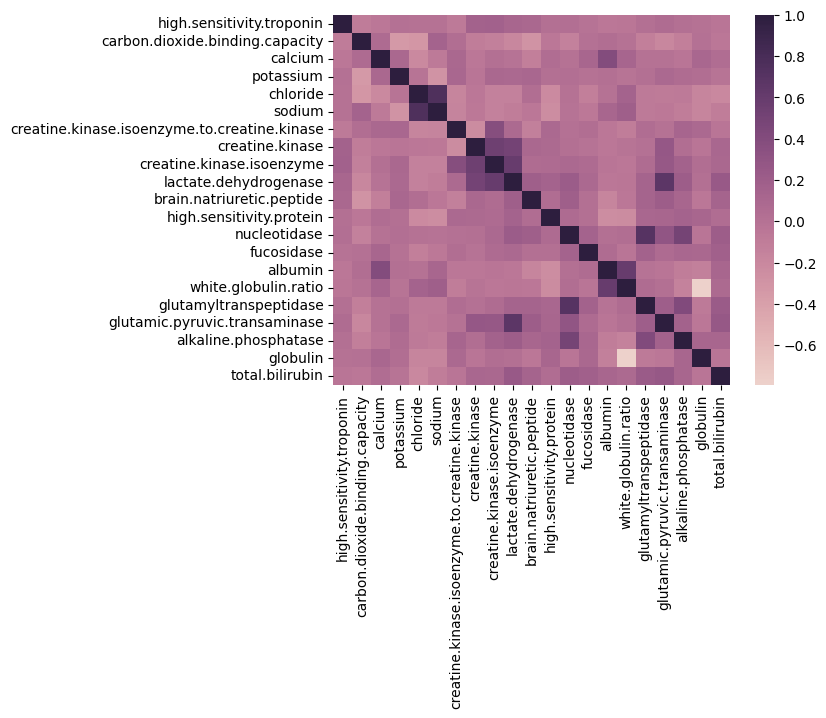

In [ ]:
temp_df_1 = scaled_df.iloc[:,46:67]
sns.heatmap(temp_df_1.corr(), annot=False,  cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

### KS test for Normality

In [ ]:
for i, x in enumerate(scaled_df.columns):
  umm = stats.kstest(df_numerical[x], 'norm')
  print(umm)

# Feature Selection

In [18]:
# ---------Features Selection------------
X_prov1 = pd.concat([dummies, scaled_df], axis=1)
y_prov1 = y_train
X_1, X_2, y_1, y_2 = train_test_split(X_prov1, y_prov1,
                                      test_size=0.30,
                                      stratify=y_prov1,
                                      random_state=321)
sel = SelectFromModel(AdaBoostClassifier(learning_rate=0.01, n_estimators=500))
sel.fit(X_1, y_1)
selected_feat = X_prov1.columns[(sel.get_support())]

X_train = X_prov1[selected_feat]    
print(X_train.shape)

# Randomize the dataset
X_train = X_train.sample(frac=1,random_state=1)
y_train = y_train.sample(frac=1,random_state=1)

(5836, 29)


# Testing set Processing

In [19]:
# ---------     Splitting    ------------
# numerical categorical splitting
df_categorical1 = Test_df_temp.select_dtypes(include=['object'])
df_numerical1 = Test_df_temp.select_dtypes(include=[np.number])
df_numerical1 = df_numerical1.reset_index()
df_categorical1 = df_categorical1.reset_index()
del df_numerical1["index"]
del df_categorical1["index"]
del df_numerical1['fio2']

# continuous numerical variables IQR for outliers 
# remove long tails
df_nbin = df_numerical1[df_numerical1.columns[(df_numerical1.nunique()>10)]] # impute values 
df_nbin2 = df_numerical1[df_numerical1.columns[(df_numerical1.nunique()<10)]] # impute values 
Q1 = df_nbin.quantile(.05)
Q3 = df_nbin.quantile(.95)
IQR=Q3-Q1
lb = Q1 - 1.5 * IQR
ub = Q3 + 1.5 * IQR
df_nbin=df_nbin[((df_nbin < ub) & (df_nbin>lb))]
df_numerical1=pd.concat([df_nbin,df_nbin2], axis = 1)


# ---------  Missing values  ------------
# categorical
# replace missing value with specific label
df_categorical1 = df_categorical1.fillna('Others')
# numerical
# replace missing value with KNN
imputed1 = KNNImputer(n_neighbors=5)
df_imputed = imputed1.fit_transform(df_numerical1)
df_numerical1 = pd.DataFrame(df_imputed, columns=df_numerical1.columns)
df_numerical1 = df_numerical1.reindex(sorted(df_numerical1.columns), axis=1)

# ---------      Dummies     ------------
# categorical to dummies
dummies1 = pd.get_dummies(df_categorical1)
print(df_numerical1.shape)

# ---------   Normalization  ------------
# use the same scaler of training set
independent_variables = df_numerical1
scaled_df1 = pd.DataFrame(scaler.transform(independent_variables))
scaled_df1.columns = independent_variables.columns
scaled_df1 = scaled_df1.reset_index()
del scaled_df1["index"]

X_test = pd.concat([scaled_df1, dummies1], axis = 1)
X_test = X_test[selected_feat]
print(X_test.shape)

(487, 84)
(487, 29)


# Modelling

### Data General View

Training set: first 1500 samples with oversampling \\
Test set: 1500-last \\

In [20]:
# General view
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5836, 29)
(5836,)
(487, 29)
(487,)


In [21]:
print(y_train.value_counts(1))

0    0.602467
1    0.397533
Name: re.admission.within.6.months, dtype: float64


### Adaboost classifier

In [ ]:
# Adaboost classifier
classifier = AdaBoostClassifier()
model_name = 'Adaboost';
parameters = {'n_estimators' : [100, 500, 1000],
              'learning_rate' : [0.0001, 0.01, 1, 10]}

best_model = hyperp_search(classifier, parameters)
report_save(best_model,model_name)

f1_train: 0.551550 using {'learning_rate': 1, 'n_estimators': 500}
f1         train 0.694   test 0.418
precision  train 0.730   test 0.363

[[230 100]
 [ 59  57]]
              precision    recall  f1-score   support

           0       0.80      0.70      0.74       330
           1       0.36      0.49      0.42       116

    accuracy                           0.64       446
   macro avg       0.58      0.59      0.58       446
weighted avg       0.68      0.64      0.66       446

AUC: 0.61


<Figure size 640x480 with 0 Axes>

### Decision Tree

In [ ]:
# Decision Tree
classifier = DecisionTreeClassifier()
model_name = 'Tree';
parameters = {'criterion': ['entropy','gini'], 
              'max_depth': [4,5,6,8,10],
              'min_samples_split': [5,10,20],
              'min_samples_leaf': [5,10,20]}

best_model = hyperp_search(classifier, parameters)
report_save(best_model,model_name)

f1_train: 0.584895 using {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10}
f1         train 0.764   test 0.350
precision  train 0.734   test 0.283

[[196 134]
 [ 63  53]]
              precision    recall  f1-score   support

           0       0.76      0.59      0.67       330
           1       0.28      0.46      0.35       116

    accuracy                           0.56       446
   macro avg       0.52      0.53      0.51       446
weighted avg       0.63      0.56      0.58       446

AUC: 0.54


<Figure size 640x480 with 0 Axes>

  ### Random Forest

In [ ]:
# Random Forest
classifier = RandomForestClassifier()
model_name = 'RandomForest';
parameters = {'n_estimators' : [100, 500, 2000],
              'criterion' : ['entropy'],
              'max_depth' : [2, 4], 
              'min_samples_split' : [2,4],
              'min_samples_leaf' : [2,4]
             }

best_model = hyperp_search(classifier, parameters)
report_save(best_model,model_name)

### Logistic Regression

In [22]:
classifier = LogisticRegression()
model_name = 'Logistic';
parameters = {"penalty": ['l1', 'l2'], 
              "C":[1e-4,1e-3,1e-2,1e-1,1,10], 
              "max_iter":[2000,3000], 
              "solver": ['saga'] }

best_model = hyperp_search(classifier, parameters)
report_save(best_model,model_name)

f1_train: 0.420759 using {'C': 10, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'saga'}
f1         train 0.430   test 0.354
precision  train 0.568   test 0.583

[[259  35]
 [144  49]]
              precision    recall  f1-score   support

           0       0.64      0.88      0.74       294
           1       0.58      0.25      0.35       193

    accuracy                           0.63       487
   macro avg       0.61      0.57      0.55       487
weighted avg       0.62      0.63      0.59       487

AUC: 0.64


<Figure size 640x480 with 0 Axes>

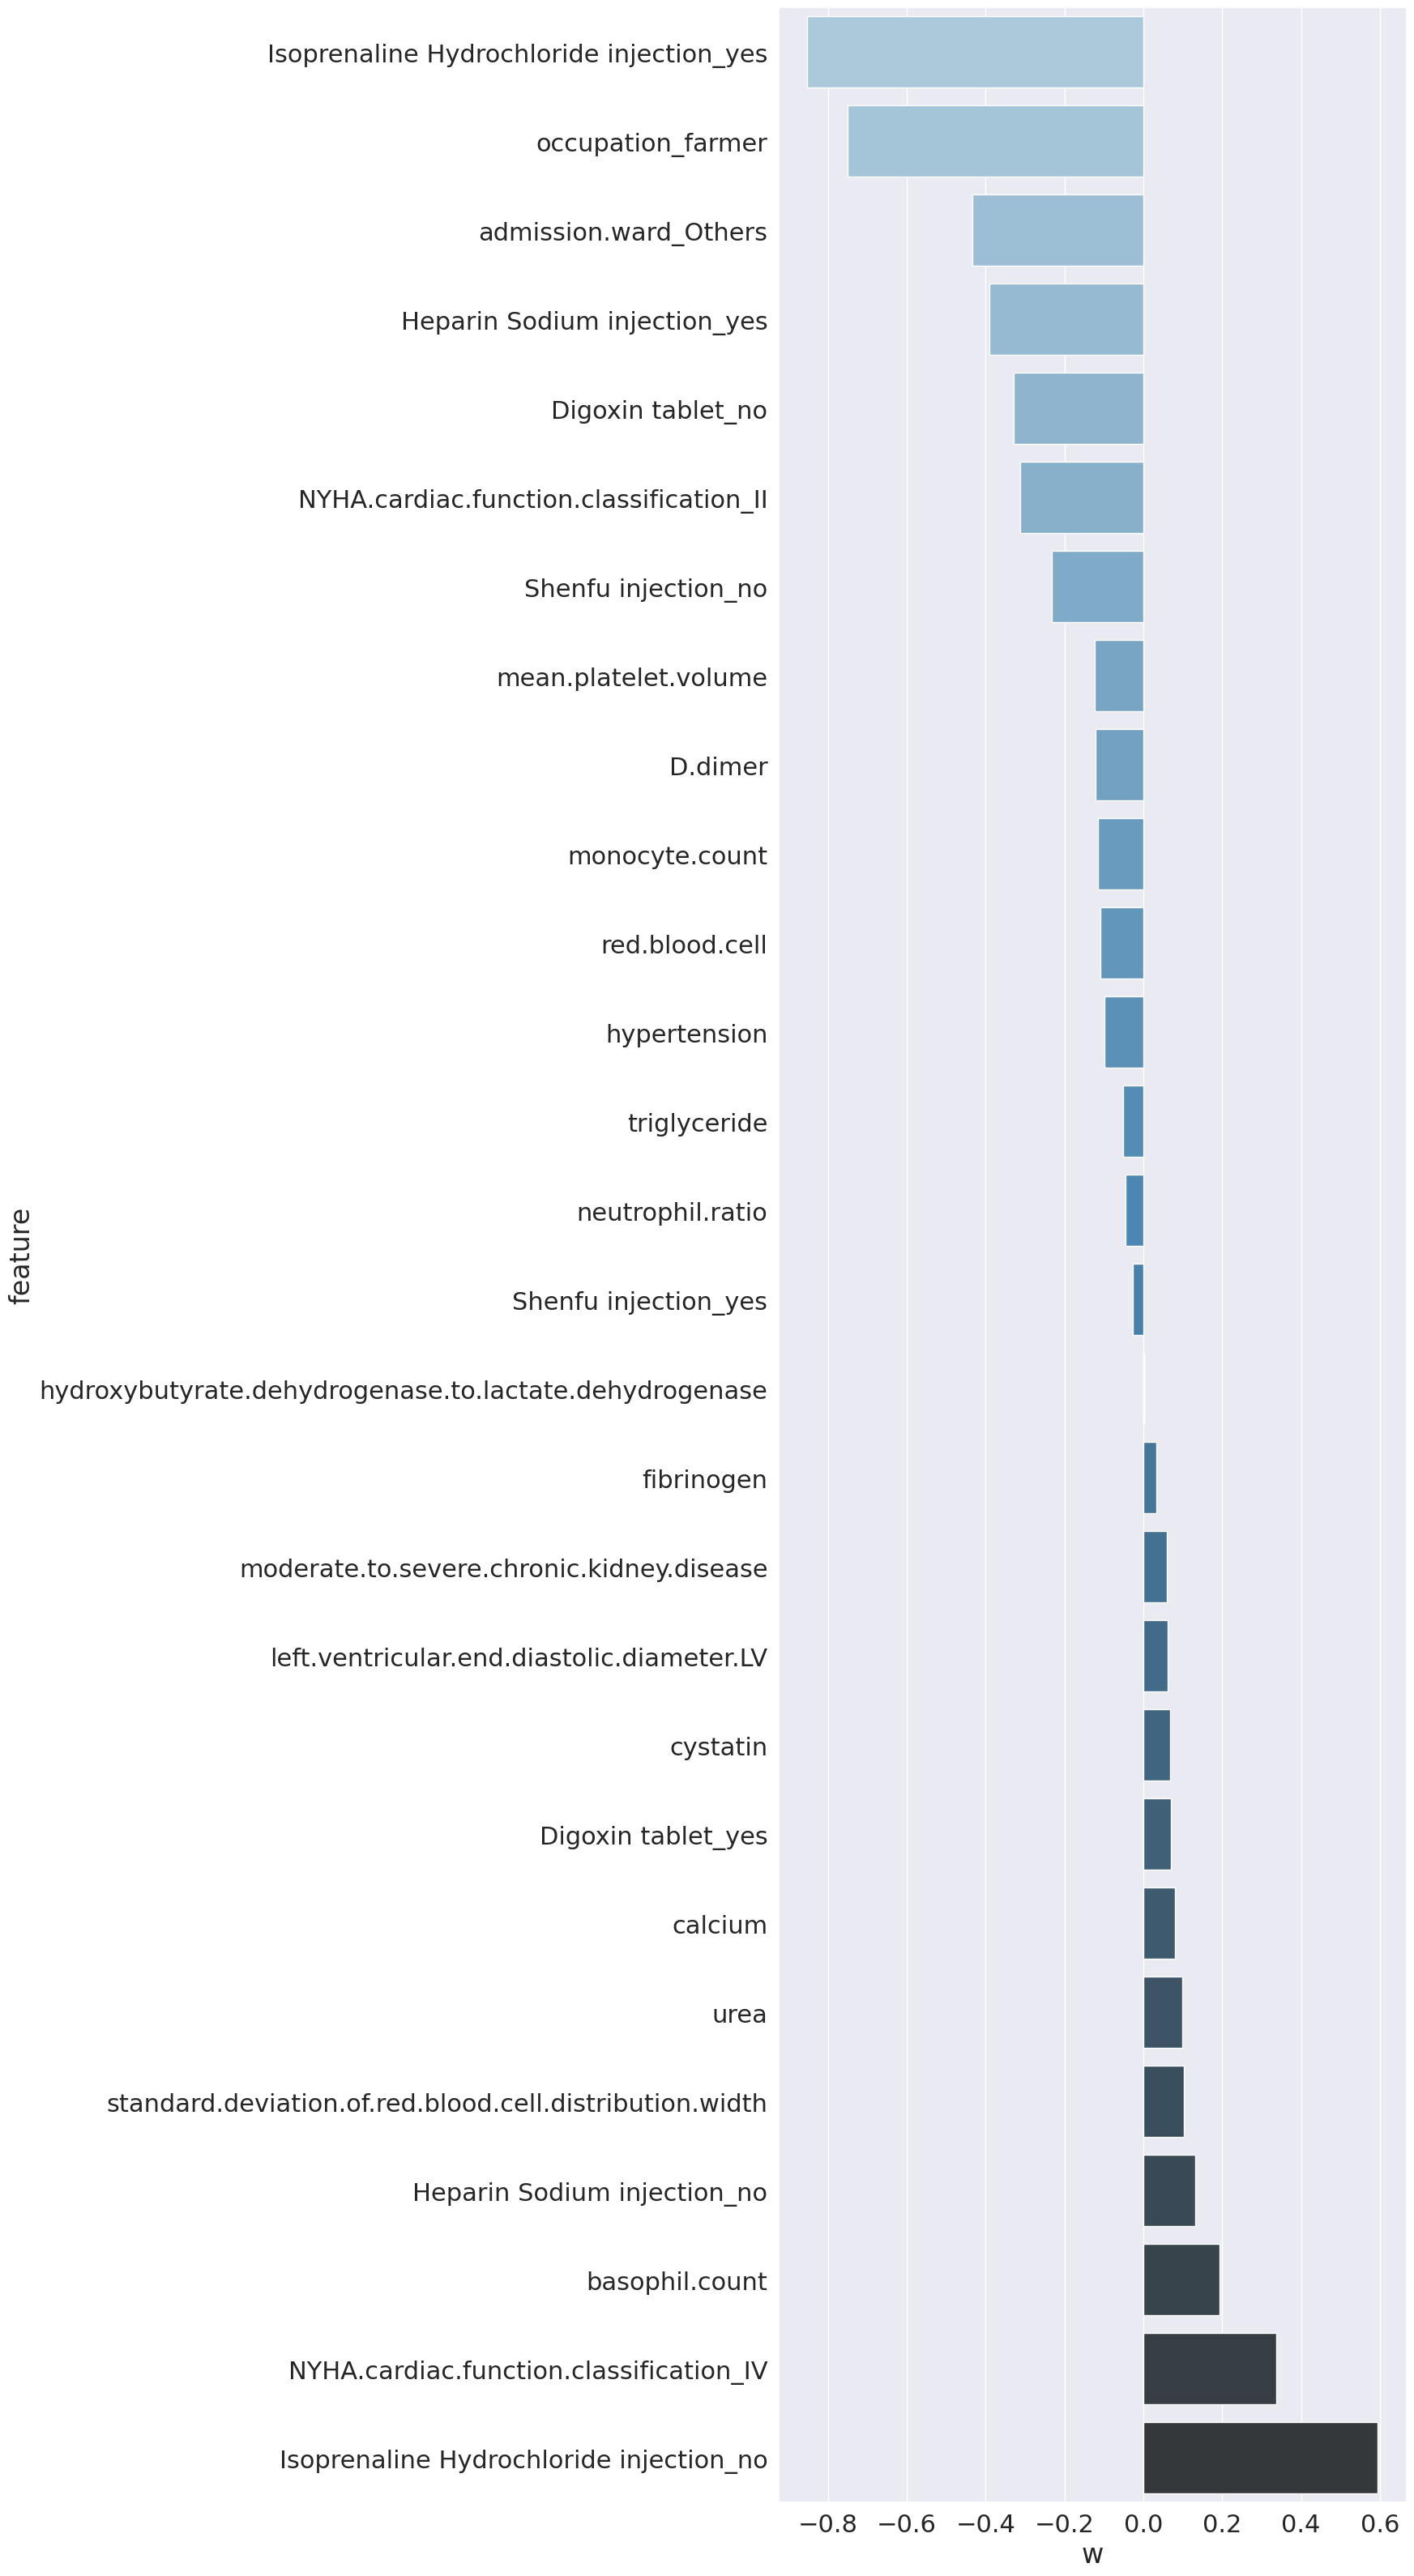

In [ ]:
# weights plot
best_model.fit(X_train,y_train)

coeff=pd.DataFrame()
coeff["feature"]=X_train.columns
coeff["w"]=best_model.coef_[0]


coeff.sort_values(by=['w'], inplace=True)
import seaborn as sns

sns.set(rc={'figure.figsize':(10, 40)})
sns.set(font_scale=2)  # Increase the font size here
sns.barplot(data=coeff, y="feature", x="w", palette="Blues_d", orient="h")
sns.set(rc={'figure.figsize':(6,4)})

### MLP Classifier

In [ ]:
classifier = MLPClassifier()
model_name = 'MLP';
parameters = {"hidden_layer_sizes":[(64,32,16),[80,40,10], [128,64,32],[16,64,8]],  
              "max_iter": [2000], 
              "alpha": [0.001,0.1]}

best_model = hyperp_search(classifier, parameters)
report_save(best_model,model_name)

f1_train: 0.702392 using {'alpha': 0.001, 'hidden_layer_sizes': [128, 64, 32], 'max_iter': 2000}
f1         train 1.000   test 0.369
precision  train 1.000   test 0.293

[[190 140]
 [ 58  58]]
              precision    recall  f1-score   support

           0       0.77      0.58      0.66       330
           1       0.29      0.50      0.37       116

    accuracy                           0.56       446
   macro avg       0.53      0.54      0.51       446
weighted avg       0.64      0.56      0.58       446

AUC: 0.55


<Figure size 640x480 with 0 Axes>

# Keras

In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 12.5 MB/s eta 0:00:00


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
import shap
from keras.models import Sequential
tfk = tf.keras
tfkl = tf.keras.layers

In [24]:
records, fts = X_train.shape
print(fts)

29


In [ ]:
# convolution model
model = Sequential()

model.add(layers.Conv1D(128,8, strides=1, activation='relu',padding='causal',input_shape=(fts,1)))
model.add(layers.Conv1D(64,3, activation='relu'))
model.add(layers.Dropout(.1))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
optimizer='sgd',
metrics=['accuracy'])
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 1,
    epochs = 5,
    validation_data=(X_test, y_test),
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-9)
   ],
  ).history

Epoch 1/5
6000/6000 [==============================] - 25s 4ms/step - loss: 0.6530 - accuracy: 0.6070 - val_loss: 0.6365 - val_accuracy: 0.6300 - lr: 0.0100
Epoch 2/5
6000/6000 [==============================] - 19s 3ms/step - loss: 0.6378 - accuracy: 0.6278 - val_loss: 0.6115 - val_accuracy: 0.6637 - lr: 0.0100
Epoch 3/5
6000/6000 [==============================] - 20s 3ms/step - loss: 0.6299 - accuracy: 0.6385 - val_loss: 0.6279 - val_accuracy: 0.6637 - lr: 0.0100
Epoch 4/5
6000/6000 [==============================] - 19s 3ms/step - loss: 0.6215 - accuracy: 0.6487 - val_loss: 0.6356 - val_accuracy: 0.6278 - lr: 0.0100
Epoch 5/5
6000/6000 [==============================] - 20s 3ms/step - loss: 0.6131 - accuracy: 0.6527 - val_loss: 0.6080 - val_accuracy: 0.6682 - lr: 0.0100


14/14 [==============================] - 0s 2ms/step


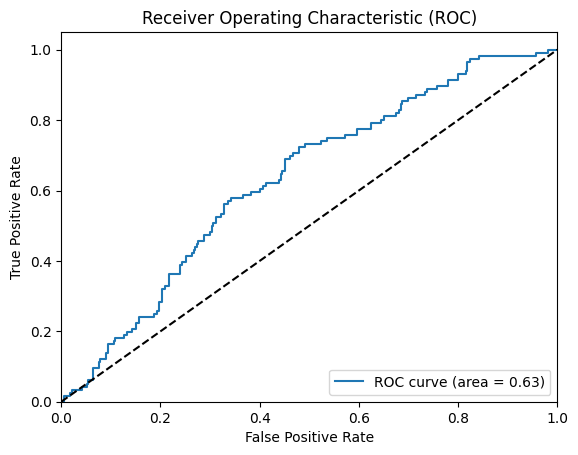

In [ ]:
# Make predictions
y_pred = model.predict(X_test).ravel()

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# fully connected
model = Sequential()

model.add(layers.Dense(256, activation='relu', input_shape=(fts,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(.2))
#model.add(layers.Embedding(input_dim=30, output_dim=64))
#model.add(layers.SimpleRNN(128))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
optimizer='sgd',
metrics=['accuracy'])
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 1,
    epochs = 5,
    validation_data=(X_test, y_test),
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-9)
   ],
  ).history

Epoch 1/5
6000/6000 [==============================] - 20s 3ms/step - loss: 0.6508 - accuracy: 0.6110 - val_loss: 0.6244 - val_accuracy: 0.6188 - lr: 0.0100
Epoch 2/5
6000/6000 [==============================] - 18s 3ms/step - loss: 0.6219 - accuracy: 0.6545 - val_loss: 0.6047 - val_accuracy: 0.6659 - lr: 0.0100
Epoch 3/5
6000/6000 [==============================] - 17s 3ms/step - loss: 0.6037 - accuracy: 0.6702 - val_loss: 0.7220 - val_accuracy: 0.5157 - lr: 0.0100
Epoch 4/5
6000/6000 [==============================] - 17s 3ms/step - loss: 0.5849 - accuracy: 0.6860 - val_loss: 0.6440 - val_accuracy: 0.6099 - lr: 0.0100
Epoch 5/5
6000/6000 [==============================] - 18s 3ms/step - loss: 0.5638 - accuracy: 0.7082 - val_loss: 0.6663 - val_accuracy: 0.6368 - lr: 0.0100


14/14 [==============================] - 0s 1ms/step


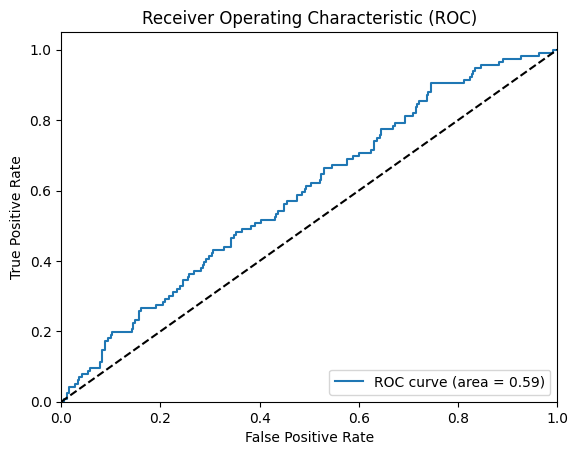

In [ ]:

# Make predictions
y_pred = model.predict(X_test).ravel()

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

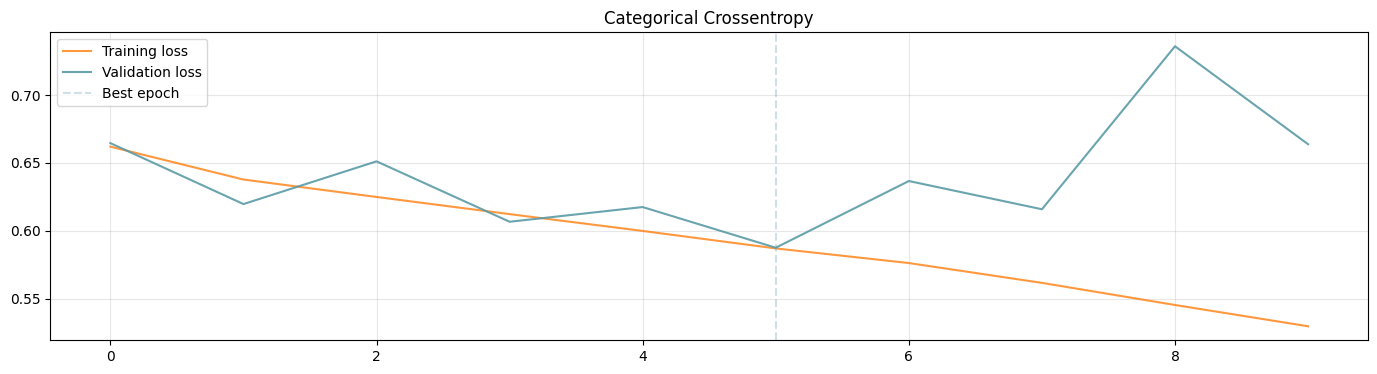

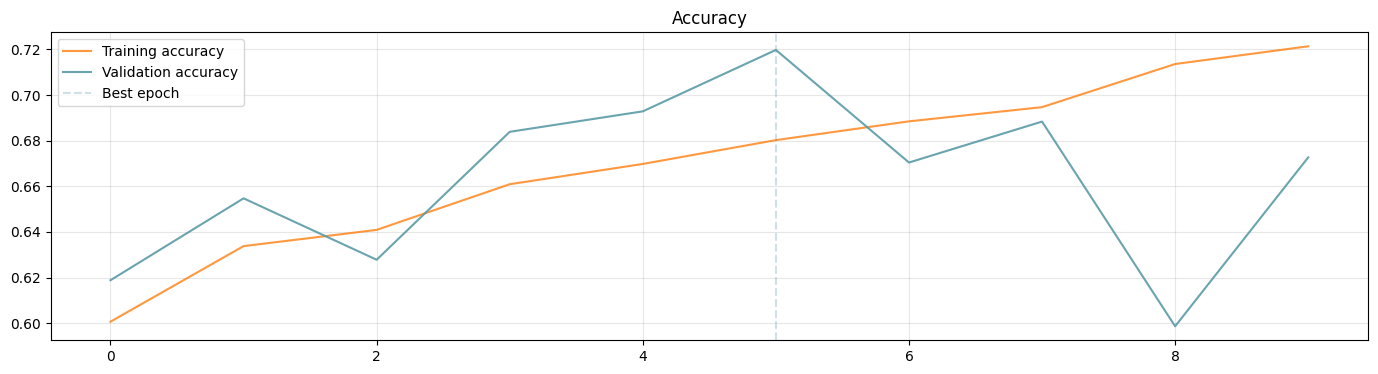

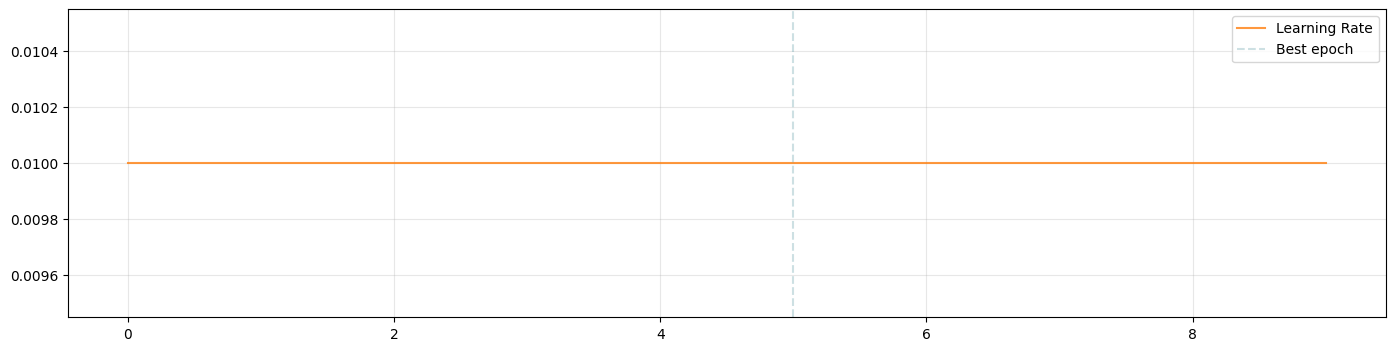

In [ ]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()
plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()
plt.figure(figsize=(17,4))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test,verbose=1)
print(score)

27/27 [==============================] - 0s 2ms/step - loss: 0.7276 - accuracy: 0.4982
[0.7275657057762146, 0.4982078969478607]


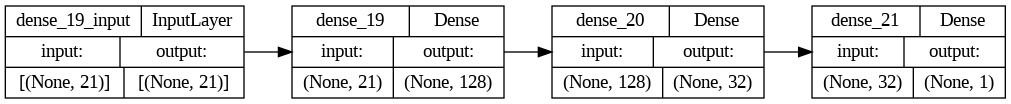

In [ ]:

# `rankdir='LR'` is to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
shap.initjs()
explainer = shap.KernelExplainer(model, X_train.iloc[:50,:])
shap_values = explainer.shap_values(X_train.iloc[3,:], nsamples=500)
shap.force_plot(explainer.expected_value, shap_values[0], X_train.iloc[3,:])

In [ ]:
shap.initjs()
shap_values50 = explainer.shap_values(X_train.iloc[50:100,:], nsamples=500)
shap.force_plot(explainer.expected_value, shap_values50[0], X_train.iloc[50:100,:])

  0%|          | 0/50 [00:00<?, ?it/s]

Thank you for scrolling all this way ;)